# **ASHRAE-Great Energy Predictor III**

#1.Introduction
In late 2019, ASHRAE hosted the Great Energy Predictor III (GEPIII) machine learning competition on the Kaggle platform. This launch marked the third energy prediction competition from ASHRAE and the first since the mid-1990s. In this updated version, the competitors were provided with over 20 million points of training data from 2,380 energy meters collected for 1,448 buildings from 16 sources. This competition’s overall objective was to find the most accurate modeling solutions for the prediction of over 41 million private and public test data points. Furthermore, the competition had 4,370 participants, split across 3,614 teams from 94 countries who submitted 39,403 predictions.


#2. Business Problem

There are significant investments been made to improve the energy efficiency of the buldings to reduce costs, emmisions and energy consumption. The building owner makes the payment based on the difference between the actual amount of energy being used and the amount which they had used without any efficiency improvement processes. The latter values comes from the machine learning model. Given the historic energy usage of more than 1400 buildings over a span of 1 year, predict the future energy usage. This will then be compared to the actual energy usage with efficiency process to understand the  cost and energy savings.

# 2. Mapping Business Problem to ML Problem
ASHRAE - Great Energy Predictor III Kaggle's competition focused on using regression-based machine learning to predict the energy savings of a retrofit in the measurement and verification (M&V) process.Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled, the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

It is a time series regression problem. The business problem is  to  improve the energy efficiency of the buildings to reduce costs, emissions and energy consumption. Doing all the improvements is not cheap at all  so for this we need Machine Learning to do this for me to develop models based on various data or factors which can lead to guide what steps we should take to improve the energy consumption 





#3. Business constraints
1. The cost of errors can be very high.
2. No strict latency concerns.
3. Interpretability is important.


#4. Data Overview:
The dataset contains several measurements from sensors placed in different kinds of buildings, and the goal is to predict the energy efficiency of a building.
The data contains information about the weather in quite a bit of detail, values like air pressure and dew temperature are also present. Regarding the building data, it seems to be more limited as there is only information about its primary use (education, residential etc.), square feet, floor count and year that the building was built. Furthermore, an important aspect of this dataset is that there can be more than one meter (a device that measures energy consumption in kW/h) in a building. This means that we can measure energy efficiency multiple times within the same building.

Here is a summary of the data:

About the data set - there are 5 files in our data set

1. train.csv

* building_id - Foreign key for the building metadata.
* meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* timestamp - When the measurement was taken
* meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

2. building_meta.csv

* site_id - Foreign key for the weather files.
* building_id - Foreign key for training.csv
* primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* square_feet - Gross floor area of the building
* year_built - Year building was opened
* floor_count - Number of floors of the building

3. weather_[train/test].csv

* Weather data from a meteorological station as close as possible to the site.
* site_id
* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second

4. test.csv

* The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.
* row_id - Row id for your submission file
* building_id - Building id code
* meter - The meter id code
* timestamp - Timestamps for the test data period

5. sample_submission.csv

* A valid sample submission.
All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.


#5. Challenges With The Dataset
Huge dataset: Train data consists of 20216100 rows (20.21 million, 2016) and test data consists of 40+ million data points (2017 and 2018 combined) which are not memory friendly at all. In such cases we must not keep unwanted data in the main memory, otherwise memory would explode and hence the process will be terminated.


#6. Performance Metrics
RMSLE this metric was selected because it is a common and straightforward adaptation of the Root Mean Square Error (RMSE) that reduces the risk that meters with much larger consumption values would unfairly influence the score significantly more than lower consuming meters


### Mount The Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb

In [ ]:
train_data = pd.read_csv("/gdrive/My Drive/case_study_data/train.csv")
weather_train_data = pd.read_csv("/gdrive/My Drive/case_study_data/weather_train.csv")
building_data = pd.read_csv("/gdrive/My Drive/case_study_data/building_metadata.csv")

In [ ]:
#Loading the test data
test_data= pd.read_csv('/gdrive/My Drive/case_study_data/test.csv')
weather_test_data=pd.read_csv('/gdrive/My Drive/case_study_data/weather_test.csv')

In [ ]:
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [ ]:
weather_train_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [ ]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
test_data.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [ ]:
weather_test_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [ ]:
#Shapes of the dataframes

print('Shape of train data:',train_data.shape)
print('Shape of weather train data:', weather_train_data.shape)
print('Shape of building meta data:', building_data.shape)
print('Shape of test data:', test_data.shape)
print('Shape of weather test data:', weather_test_data.shape)


Shape of train data: (20216100, 4)
Shape of weather train data: (139773, 9)
Shape of building meta data: (1449, 6)
Shape of test data: (41697600, 4)
Shape of weather test data: (277243, 9)


In [ ]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [ ]:
train_data= reduce_mem_usage(train_data, use_float16=True)
weather_train_data= reduce_mem_usage(weather_train_data, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [ ]:
test_data= reduce_mem_usage(test_data)
weather_test_data= reduce_mem_usage(weather_test_data)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%


### Merge the data into train and test dataframe

In [ ]:
train_df= train_data.merge(building_data, on='building_id', how='left')

In [ ]:
train_df=train_df.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [ ]:
test_df= test_data.merge(building_data, on='building_id', how='left')

In [ ]:
test_df=test_df.merge(weather_test_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype   
---  ------              -----   
 0   building_id         int16   
 1   meter               int8    
 2   timestamp           category
 3   meter_reading       float32 
 4   site_id             int64   
 5   primary_use         object  
 6   square_feet         int64   
 7   year_built          float64 
 8   floor_count         float64 
 9   air_temperature     float16 
 10  cloud_coverage      float16 
 11  dew_temperature     float16 
 12  precip_depth_1_hr   float16 
 13  sea_level_pressure  float16 
 14  wind_direction      float16 
 15  wind_speed          float16 
dtypes: category(1), float16(7), float32(1), float64(2), int16(1), int64(2), int8(1), object(1)
memory usage: 1.3+ GB


In [ ]:
train_df.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [ ]:
train_df.isnull().sum() * 100 / train_df.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.990033
floor_count           82.652772
air_temperature        0.478124
cloud_coverage        43.655131
dew_temperature        0.495348
precip_depth_1_hr     18.544739
sea_level_pressure     6.092515
wind_direction         7.167792
wind_speed             0.710701
dtype: float64

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
 #   Column              Dtype   
---  ------              -----   
 0   row_id              int32   
 1   building_id         int16   
 2   meter               int8    
 3   timestamp           category
 4   site_id             int64   
 5   primary_use         object  
 6   square_feet         int64   
 7   year_built          float64 
 8   floor_count         float64 
 9   air_temperature     float16 
 10  cloud_coverage      float16 
 11  dew_temperature     float16 
 12  precip_depth_1_hr   float16 
 13  sea_level_pressure  float16 
 14  wind_direction      float16 
 15  wind_speed          float16 
dtypes: category(1), float16(7), float64(2), int16(1), int32(1), int64(2), int8(1), object(1)
memory usage: 2.8+ GB


In [ ]:
test_df.isnull().sum()

row_id                       0
building_id                  0
meter                        0
timestamp                    0
site_id                      0
primary_use                  0
square_feet                  0
year_built            24598080
floor_count           34444320
air_temperature         221901
cloud_coverage        19542180
dew_temperature         260799
precip_depth_1_hr      7801563
sea_level_pressure     2516826
wind_direction         2978663
wind_speed              302089
dtype: int64

In [ ]:
test_df.isnull().sum() * 100 / test_df.shape[0]

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count           82.605042
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

As we can see we have a few columns with missing values. I will imputate them later, first I will do EDA.May be i have to drop floor_count and year_built before feed to my model because more than 50% of data is missing here

Convert datetime varibales into pandas dataframe

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/05/datetime-variables-python-pandas/
#I will break the timestamp into hour of the day, day of the week and month of the year
#https://stackoverflow.com/questions/33365055/attributeerror-can-only-use-dt-accessor-with-datetimelike-values
def convert_timestamp_data(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp'].dt.day)
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

train_df= convert_timestamp_data(train_df)
test_df = convert_timestamp_data(test_df)

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


In [ ]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,0,2017-01-01,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,6,1,1,1,2017
1,1,1,0,2017-01-01,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,6,1,1,1,2017
2,2,2,0,2017-01-01,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,6,1,1,1,2017
3,3,3,0,2017-01-01,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,6,1,1,1,2017
4,4,4,0,2017-01-01,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,6,1,1,1,2017


In [ ]:
min(train_df.timestamp)

Timestamp('2016-01-01 00:00:00')

In [ ]:

print("print the basic information about train data")


key_list = ["Min date value in the train set :",
            "Max date value in the train set :",
            "No of unique buildings :",
            "No of rows in the train set :",
            "Min date value in the train set :",
            "Max date value in the train set :",
            "No of unique site id :"]


value_list = [min(train_df.timestamp),
              max(train_df.timestamp),
              len(train_df.building_id.unique()),
              len(train_df),
              min(train_df.meter_reading),
              max(train_df.meter_reading),
              len(train_df.site_id.unique())]

final_list = zip(key_list, value_list)
for i in final_list:
    print(i[0], i[1])

print the basic information about train data
Min date value in the train set : 2016-01-01 00:00:00
Max date value in the train set : 2016-12-31 23:00:00
No of unique buildings : 1449
No of rows in the train set : 20216100
Min date value in the train set : 0.0
Max date value in the train set : 21904700.0
No of unique site id : 16


## Observation

* We have details about building id (a number used to identify buildings), meter type {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}, timestamp (time at with reading was recorded) and the meter reading (meter reading is our target variable)
* https://www.kaggle.com/c/ashrae-energy-prediction/data how i would know that there are types of meter in my data set which belong to 4 categories is mentioned in this link and also full information is available regarding with the data  

* I am dealing with time-series data

* This train dataset contains meter reading entries(4 meter types) of year 2016(366 days) for 1449 unique buildings per hour (total row should be 366 * 24 * 4 * 1449) that is equal to 50912064

* I have 20,216,100_ meter reading entries. The reason why we have 20 million records and not 50 million is that not all the buildings have all types of meters.

* Minimum meter reading is 0 and maximum meter reading is 21904700.0 (both are may be outliers)

* There are a total of 16 different sites


* So, we also have meter reading value "0", which is not normal . There must be some reasons behind it.
  
 * **Seasonal reasons**: We have 4 meter types (0:electricity, 1: chilledwater, 2: steam, 3: hotwater), If we have 0 meter reading for any among 3 meters (excluding electricity meter, because overall electricity will be used) it might because chilled water won't be used in winter season or hotwater or steam devices are not used at all in the summer season.

 * **Closed building, Under construction or At maintenance**: This could be another factor when we have a meter reading of 0.

 * **Error in measuring instrument(error in the meter itself)**: This could be another reason, Here there is a glitch or fault in the instrument itself.


Distribution plot: meter_reading

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


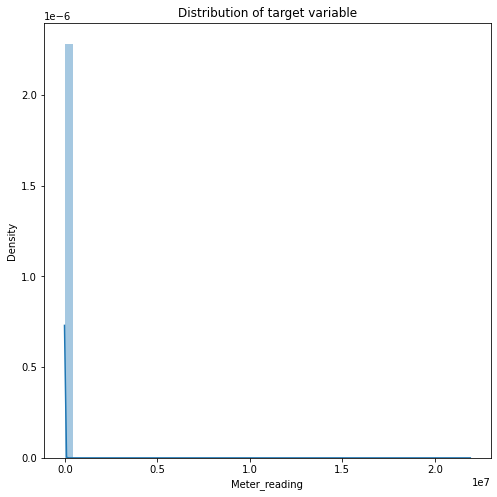

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

As we can see our target variable heavily skewed and not much of insights can be gathered from the above plot. Hence I will use log transformation because as it is heavily skewed towards left, 
this metric was selected because it is a common and
straightforward adaptation of the Root Mean Square Error
(RMSE) that reduces the risk that meters with much larger
consumption values would unfairly influence the score significantly more than lower consuming meters and it is also mention in the Kaggle in the evaluation metrics that we can use Root Mean Squared Logarithmic Error (RMSLE) instead of RMSE 

In [ ]:
train_df["meter_reading"] = np.log1p(train_df["meter_reading"])

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


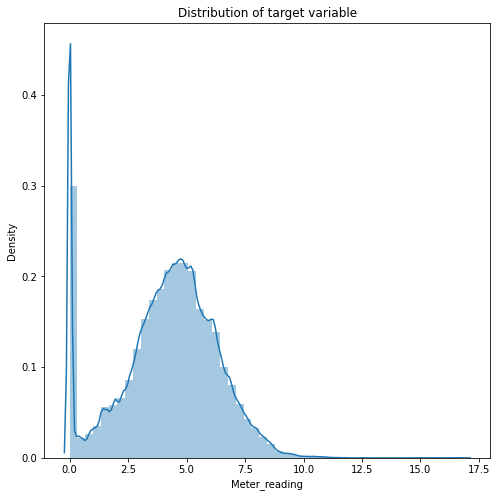

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

We can see from the above plot that maximum readings are zero and the plot has good variance now after transformation.

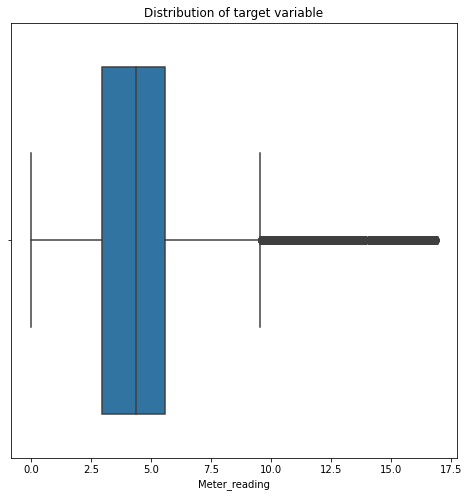

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(x = train_df['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

In this plot we seen that our mean is near about 4.0 we can also use descibe function to get better understanding of meter data

In [ ]:
train_df.meter_reading.describe()

count    2.021610e+07
mean     4.208398e+00
std      2.074255e+00
min      0.000000e+00
25%      2.960105e+00
50%      4.379210e+00
75%      5.594652e+00
max      1.690221e+01
Name: meter_reading, dtype: float64

Box plot hour data

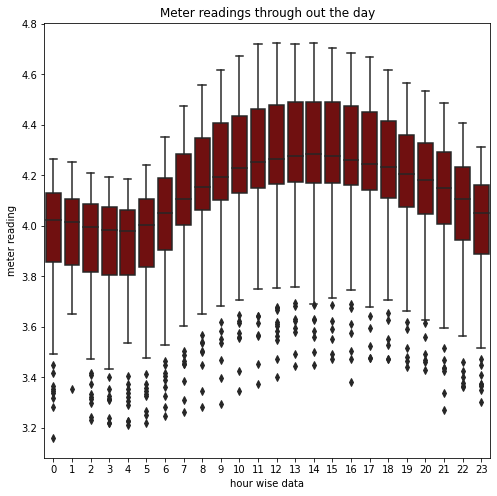

In [ ]:
plt.figure(figsize=(8,8))
hour_data = train_df.groupby(["timestamp", "hour"]).meter_reading.mean().reset_index()
sns.boxplot(x=hour_data['hour'], y=hour_data['meter_reading'], color ='maroon', data=hour_data)
plt.xlabel("hour wise data")
plt.ylabel("meter reading")
plt.title("Meter readings through out the day")
plt.show()

It is observerd from the above plot that the meter readings drop in the early hours of the morning around 4am and rises again after 5am. The hourly usage peaks in the afternoon arpund 3pm. This behaviour is normal as most of institutes, industries and other buildings are fully operational during this time.

daysofweek violin plot

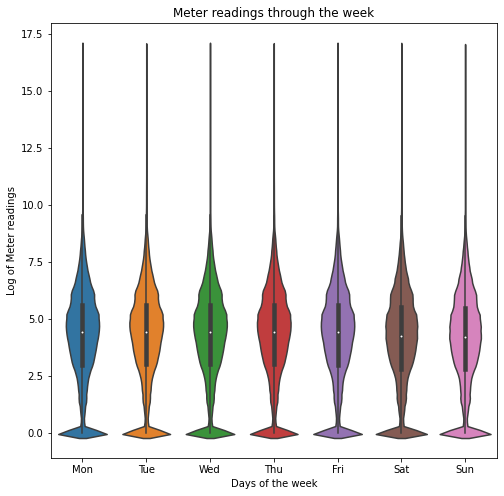

In [ ]:
#Lets check the day wise usage of power
plt.figure(figsize=(8,8))
day_labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
p=sns.violinplot(x=train_df['dayofweek'], y=train_df['meter_reading'], pallete='muted')
p.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the week")
plt.show()

There is not much of a difference in day to day basis of usage.

monthly usage barplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


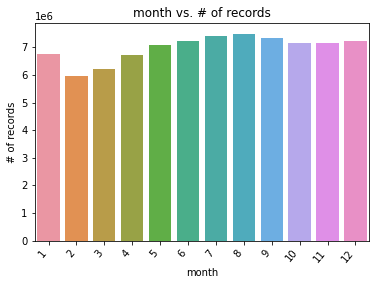

In [ ]:
ax = sns.barplot(train_df.groupby('month').meter_reading.agg('sum').reset_index()['month'],
                train_df.groupby('month').meter_reading.agg('sum').reset_index()['meter_reading'])
ax.set(xlabel='month', ylabel='# of records', title='month vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

it does not provide much informatiobn because all months are almost same 

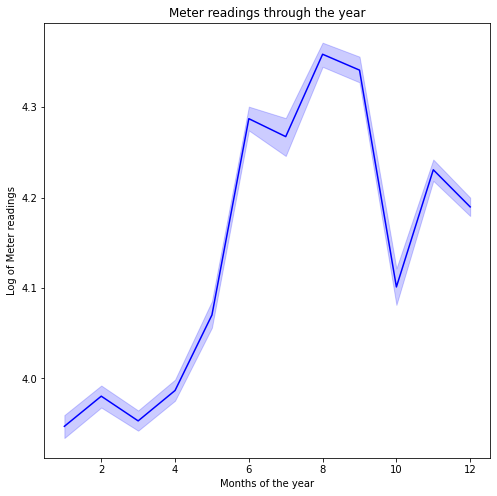

In [ ]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
timestamp_month_df= train_df.groupby(['timestamp','month']).meter_reading.mean().reset_index()
sns.lineplot(x=timestamp_month_df['month'], y=timestamp_month_df['meter_reading'], color='blue')
plt.xlabel("Months of the year")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings through the year")
plt.show()

The average monthly consumption is minimal in the initial months and then rises after the month of april. It peaks in june to september may be because there is more heat in the weather lot of bulidings used ac's and duct ac's which runs cotinousuly throught out the day and starts dropping again in winter months.

In [ ]:
train_df.meter.replace({0:"electricity", 1:"chilledwater", 2:"steam", 3:"hotwater"}, inplace=True)

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
0,0,electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
1,1,electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
2,2,electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
3,3,electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016
4,4,electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,4,1,1,1,2016


### Count plot for Meter types

In [ ]:
train_df.meter.value_counts()

electricity     12060910
chilledwater     4182440
steam            2708713
hotwater         1264037
Name: meter, dtype: int64

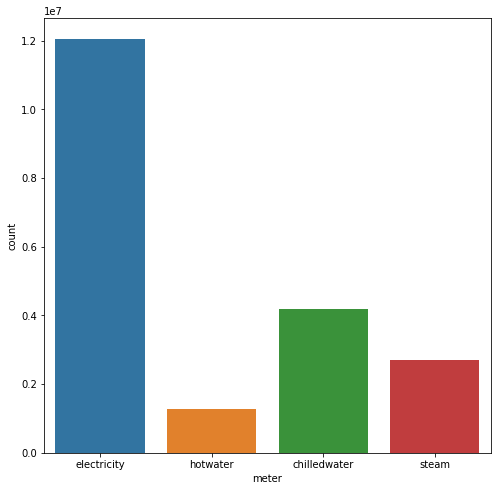

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x="meter", data=train_df) 

We have the maximum meter readings for electricity followed by chilled water and steam. The lowest readings are for hotwater.

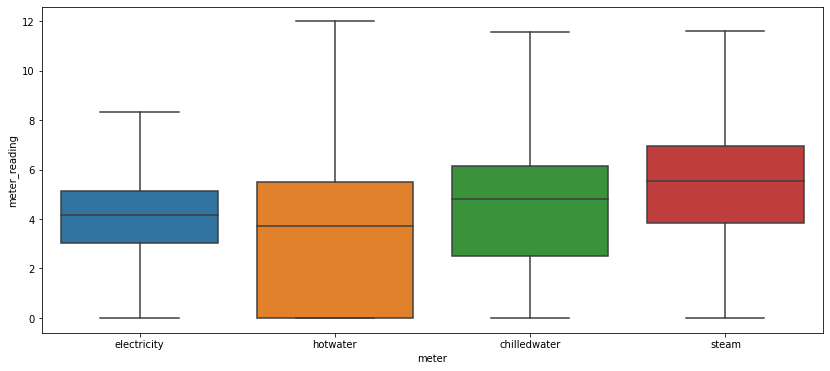

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train_df, showfliers=False);

Average meter reading by meter types

In [ ]:
meter_df= train_df.groupby('meter').meter_reading.mean().reset_index()
meter_df.head()

,meter,meter_reading
0,chilledwater,4.246052
1,electricity,3.977567
2,hotwater,3.324528
3,steam,5.123080


Text(0.5, 1.0, 'Average meter readings by meter types')

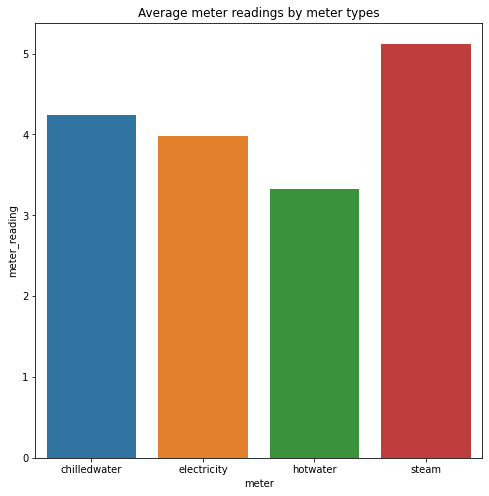

In [ ]:
#Meter readings for each meter category
plt.figure(figsize=(8,8))
ax= sns.barplot(x='meter', y='meter_reading', data=meter_df)
plt.title("Average meter readings by meter types")

Steam consumes most power and hotwater consumes least power.

### Count plots of primary use

In [ ]:
train_df.primary_use.value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

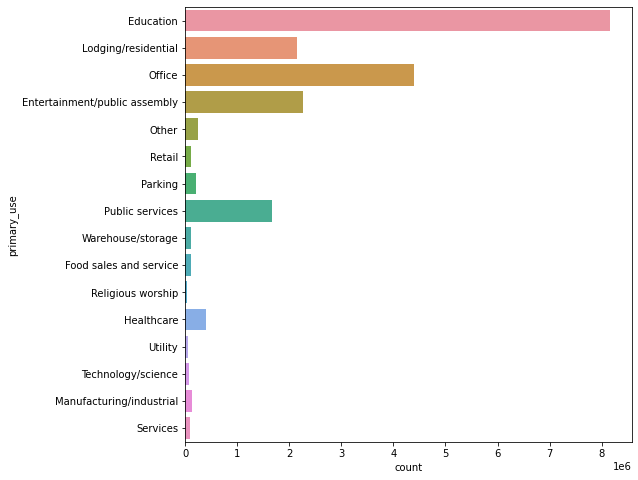

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='primary_use', data=train_df)

Most number of readings are present for educational institutes followed by office, enetertainment and Lodging/residential buildings.

Energy Usage By Building Type

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


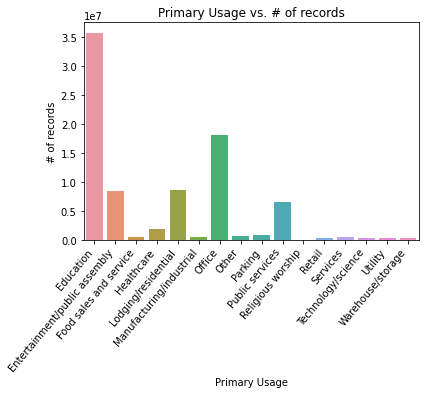

In [ ]:
ax = sns.barplot(train_df.groupby('primary_use').meter_reading.agg('sum').reset_index()['primary_use'],
                train_df.groupby('primary_use').meter_reading.agg('sum').reset_index()['meter_reading'])
ax.set(xlabel='Primary Usage', ylabel='# of records', title='Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

Energy_Type Count for each primary_use

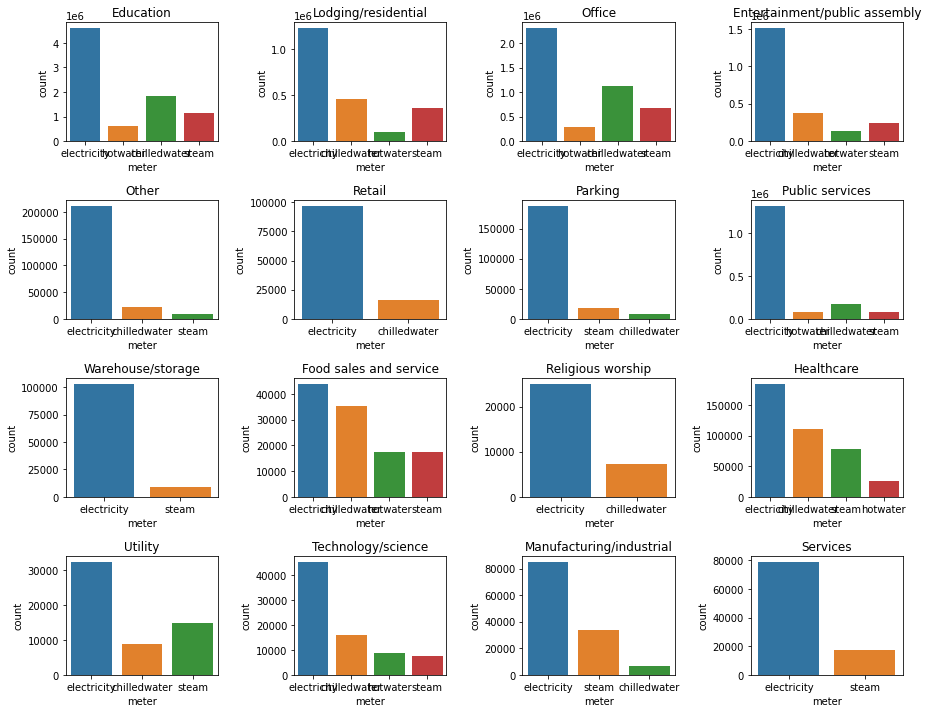

In [ ]:
#https://www.kaggle.com/masoudmzb/eda-how-to-detect-noises
fig, axes = plt.subplots(nrows=4, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(15)
# fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
primary_uses = train_df.primary_use.unique()

for i, primary_use in enumerate(primary_uses):
    sns.countplot(x="meter", data = train_df[train_df.primary_use  == primary_use],ax=axes[i//4,i%4]).title.set_text(str(primary_use))

From above plots it is clearly seen that the primary use of electicity in all the sectors here which make more sense because without electicity none of the work is done

Average hour consumption of the primary use

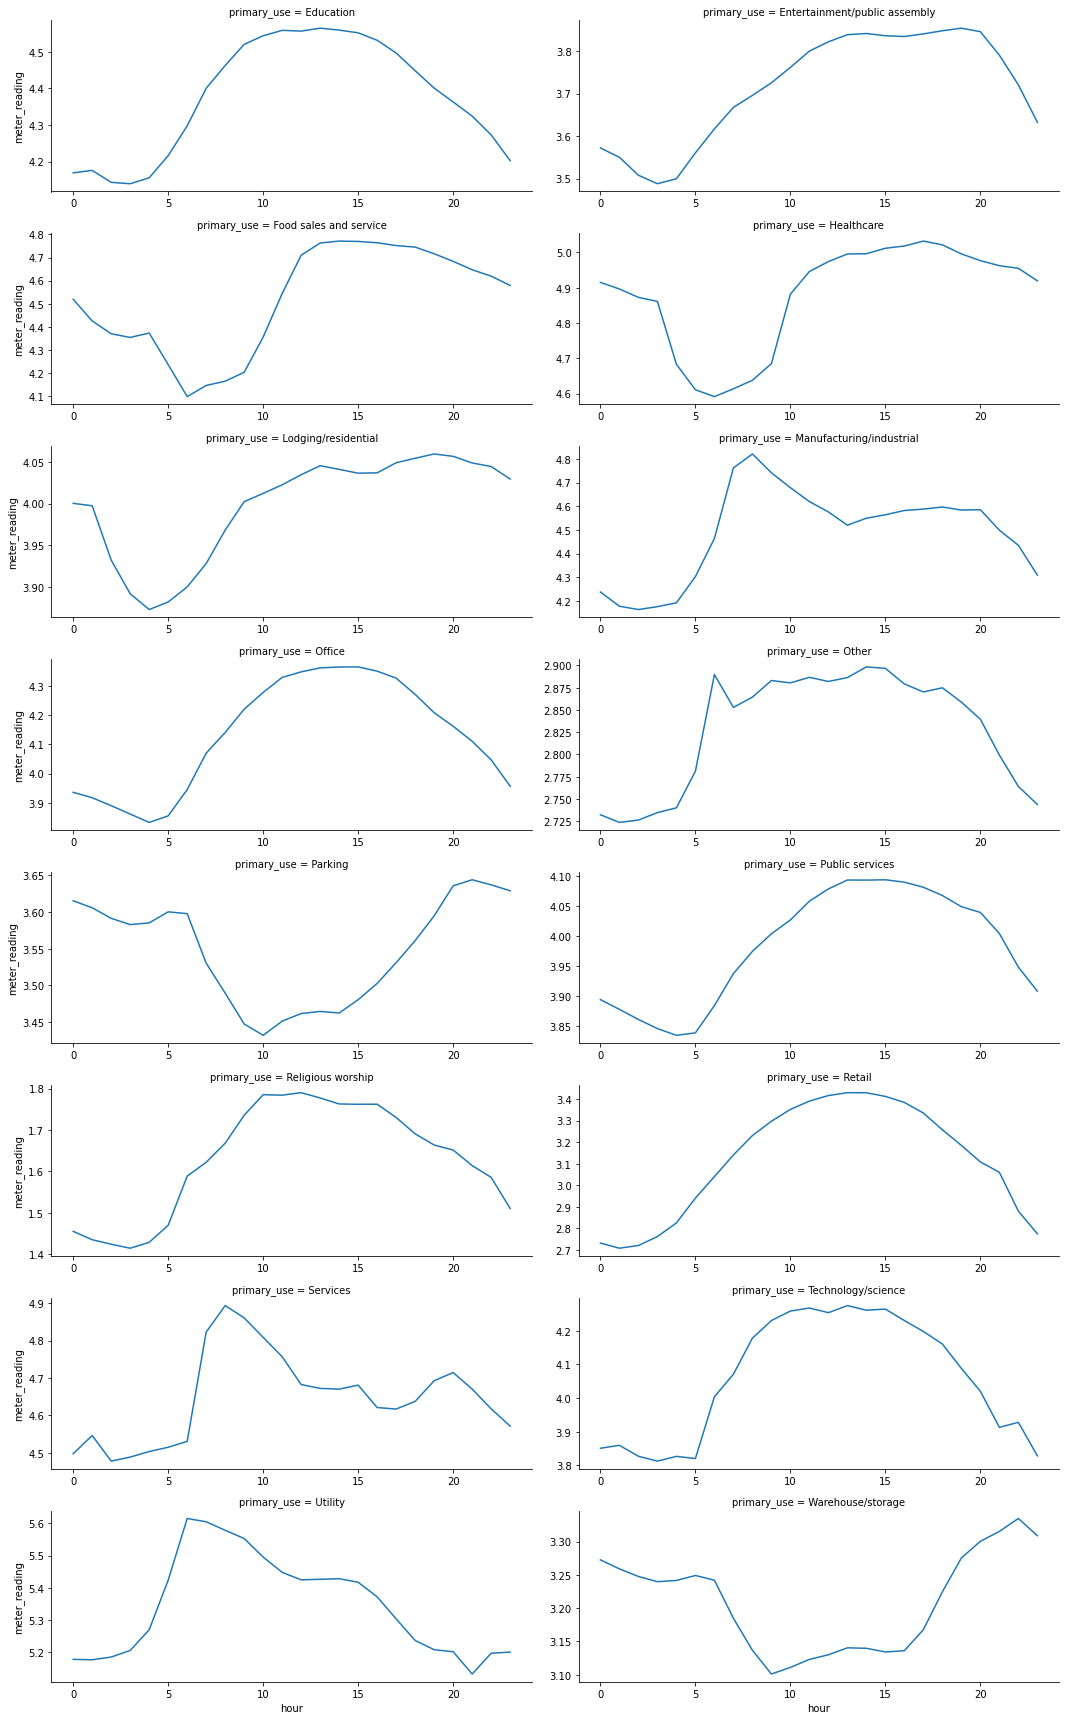

In [ ]:
hour_primary_df = train_df.groupby(["hour", "primary_use"]).meter_reading.mean().reset_index()
F = sns.FacetGrid(hour_primary_df, col="primary_use", col_wrap=2, height=3, aspect=2.5, sharey=False, sharex=False)
F.map(sns.lineplot, "hour", "meter_reading")
plt.show()

In the above figure, we have plotted the average hourly usage for each of the primary usage category.



*   The peak usage for educational institutes have the peak usage from morning 9 am until 3 pm and then the usage drops. This is explained as most educational institutes are operational during day time only.
*   The consumption for enetertainmet as well as food sales buildings rises after 10 and and continues to remain stable until 8 pm.
*   The healthcare and residential buildings have a similar behavious of usage as it peaks around 4 pm and then drops in the evening.
*   The office buildings, retail, technology and public services buildings also consume most of the energy in the daytime mainly from 10 am to 4 pm.
*   The parkings have the minimum usage in th morning hours and the consumption rises after 3 pm.
*   The religious buildings consumes the least energy
* The warehouse/Storage the peaks hour is in the mid night and in the early hours of the day is because most of the loading and unloading of the matreial
doing in that hours of the day










 Average month consumption of the primary use

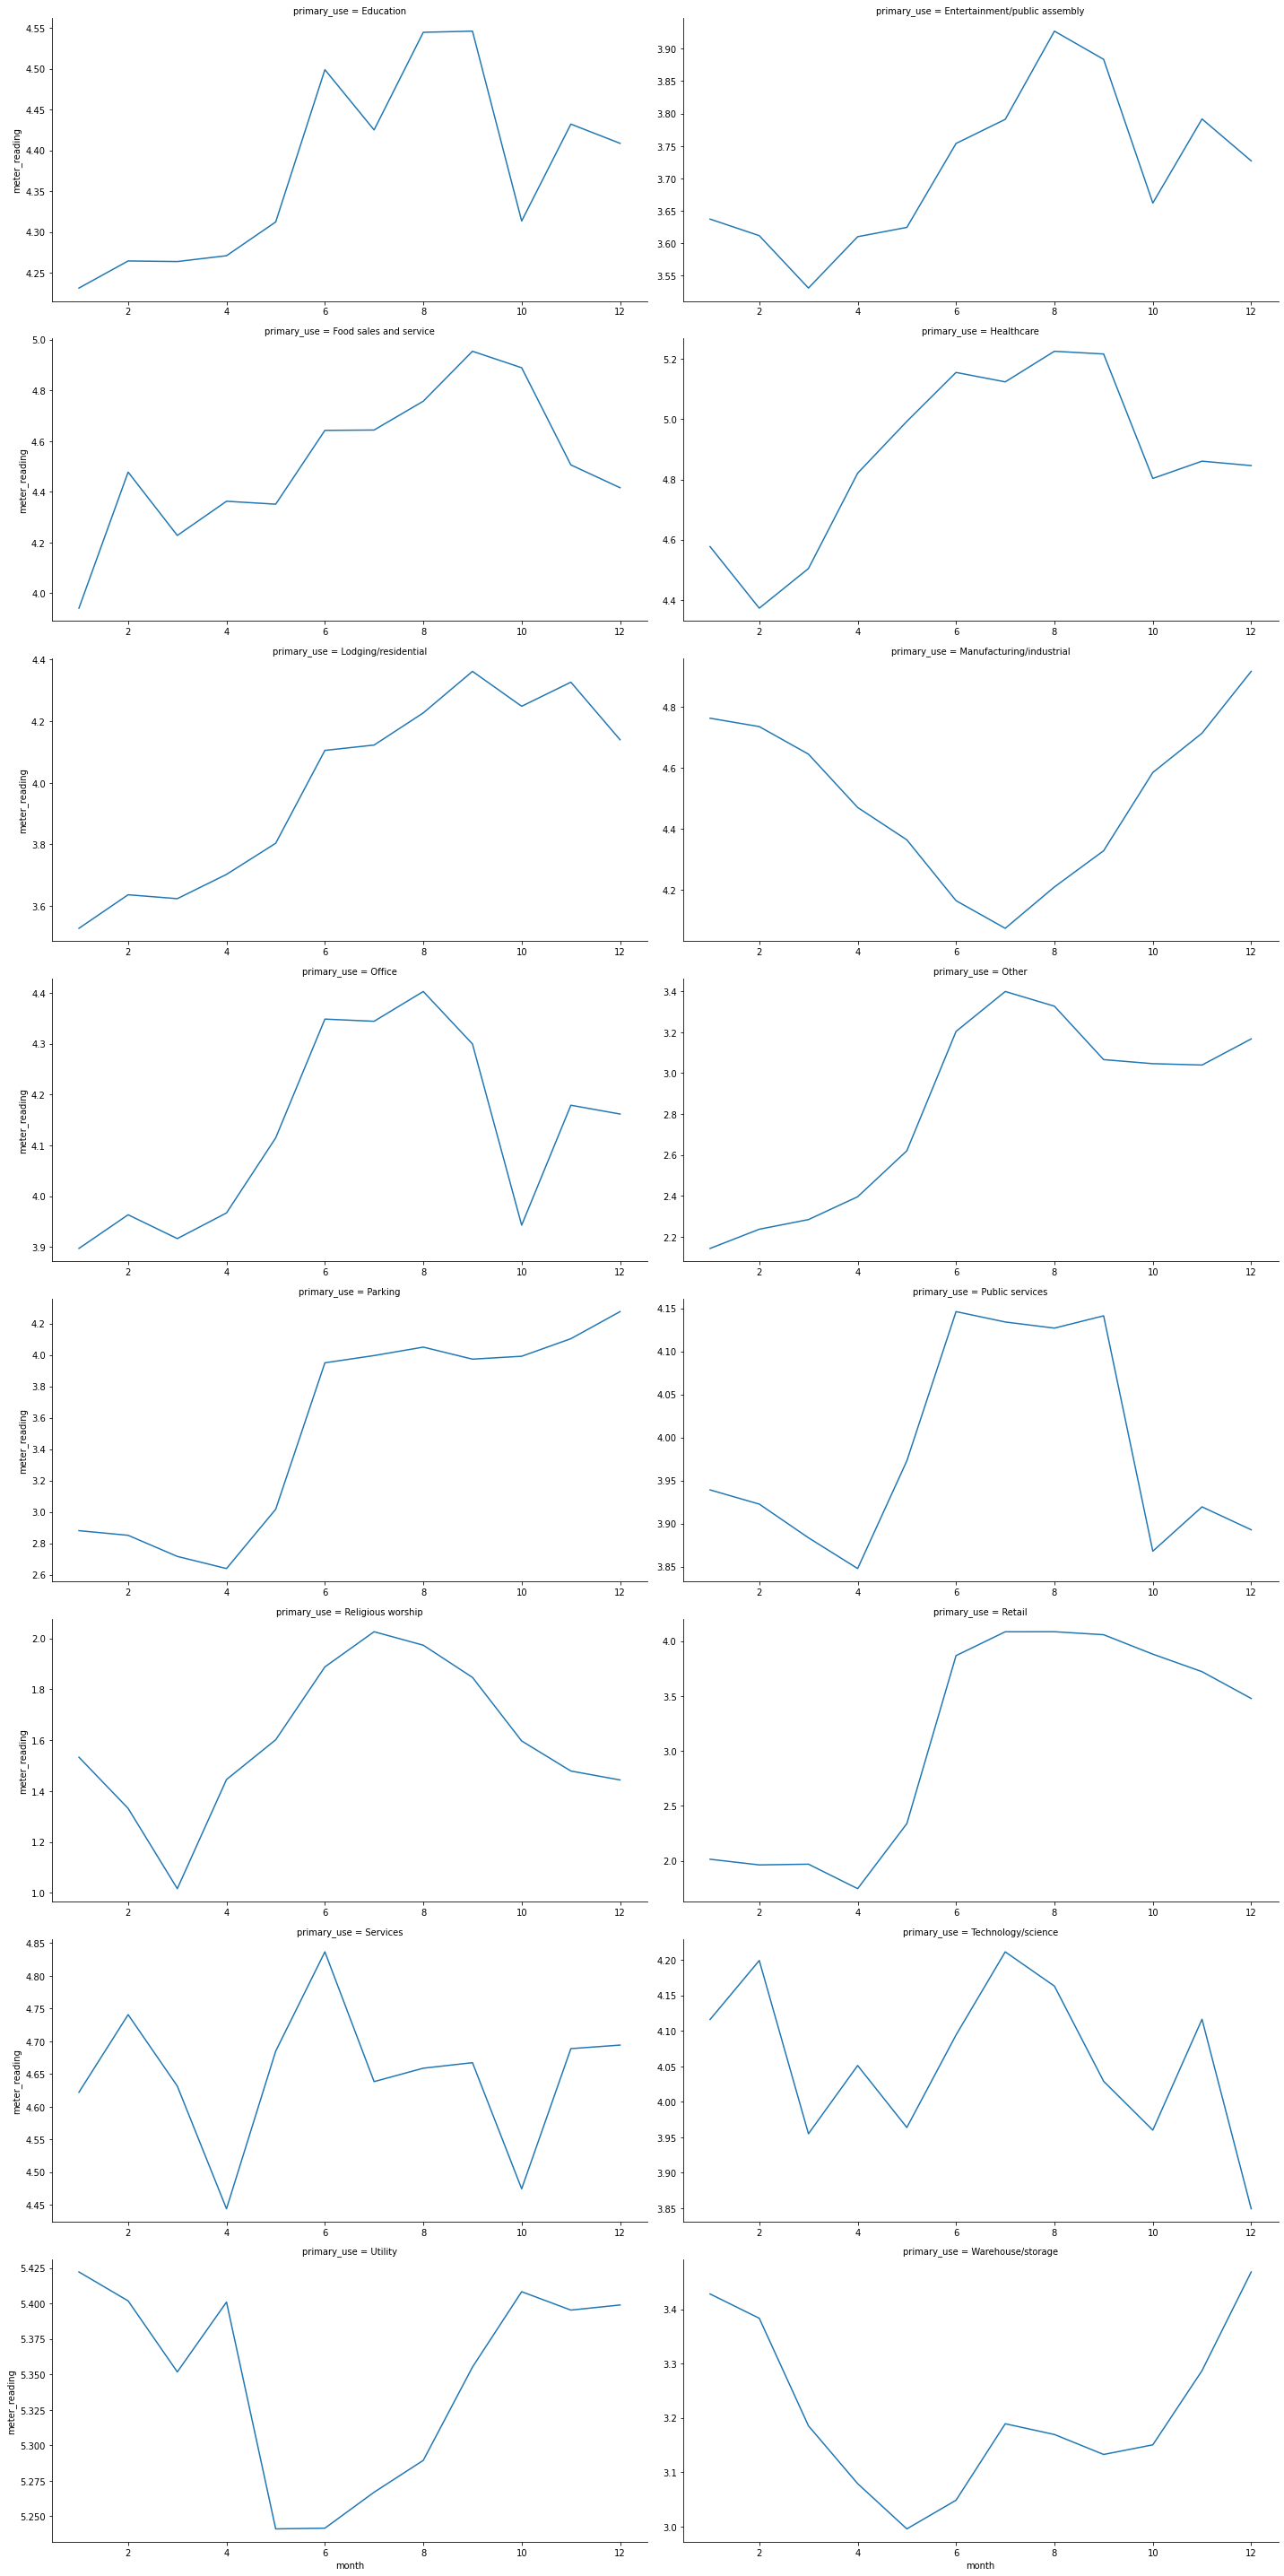

In [ ]:
#Monthy average readings based on type of buildings
month_primary_df= train_df.groupby(['month', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(month_primary_df, col='primary_use', col_wrap=2, height=5, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'month', 'meter_reading')
plt.show()

In the above figure, we have plotted the average hourly usage for each of the primary usage category.



*   The educational institutes have the peak usage in August and September. The usage is minimum in the initial months of the year.
*   The consumption for enetertainment as well as food sales buildings rises is minimum  around March and maximum in August.
*  There is a clear decreasing trend for manufacturing which hits the minimum in the july month and then starts rising again.


Distribution Plot: Air Temperature

In [ ]:
train_df.air_temperature.isnull().sum()

96658

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


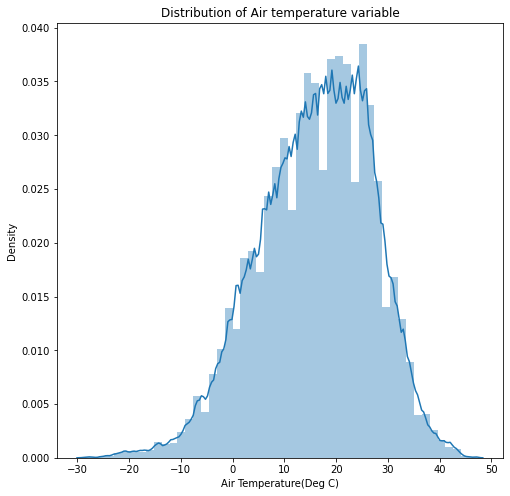

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['air_temperature'].dropna())
plt.xlabel("Air Temperature(Deg C)")
plt.title("Distribution of Air temperature variable")
plt.show()

The air temperature roughly follows a normal distribution. The maximum observations lie between 0-30 deg C.

box plot of air temperature

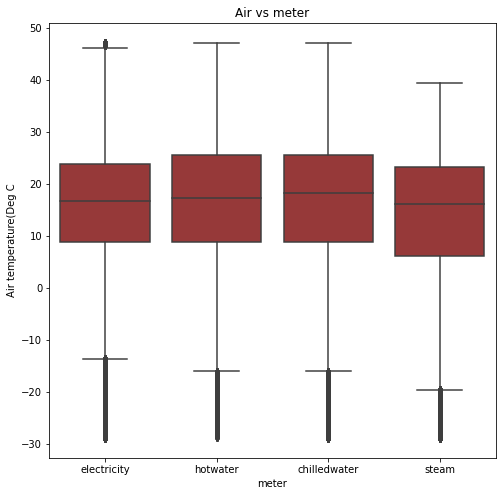

In [ ]:
plt.figure(figsize=(8,8))
air_meter_df = train_df[["meter", "air_temperature"]]
sns.boxplot(x = air_meter_df["meter"], y=air_meter_df["air_temperature"], color="brown", data=air_meter_df)
plt.xlabel("meter")
plt.ylabel("Air temperature(Deg C")
plt.title("Air vs meter")
plt.show()

mean meter reading of air temperature

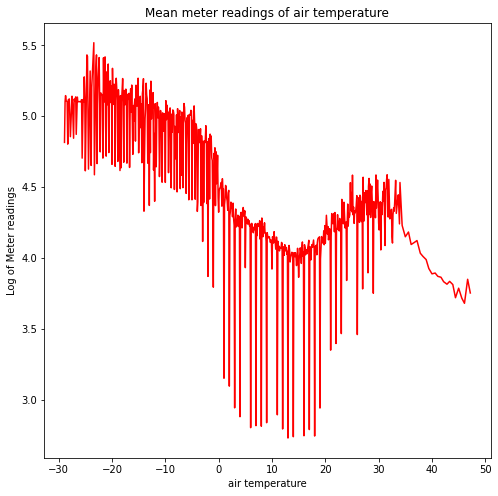

In [ ]:
plt.figure(figsize=(8,8))
temp_air_df= train_df.groupby('air_temperature').meter_reading.mean().reset_index()
sns.lineplot(x=temp_air_df['air_temperature'], y=temp_air_df['meter_reading'], color='red')
plt.ylabel("Log of Meter readings")
plt.xlabel("air temperature")
plt.title("Mean meter readings of air temperature")
plt.show()

The meter readings are high when the temperature is negative it make sense because we already seen the steam is the least energy efficient, once air temperature starts increasing, the meter consumption reduces. It again increases when the temperature rises above 15 deg C.

Mean temperatures of site ids

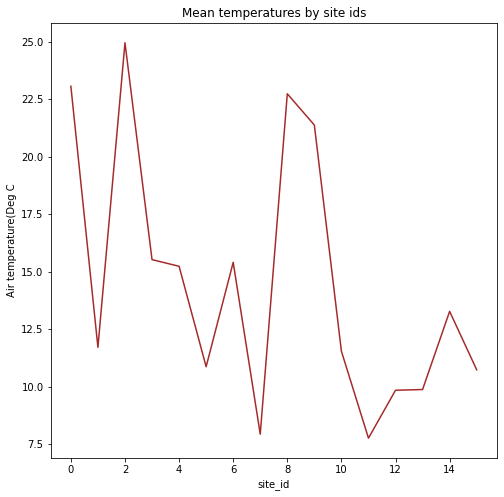

In [ ]:
plt.figure(figsize=(8,8))
air_site_df = train_df.groupby(["site_id"]).air_temperature.mean().reset_index()
sns.lineplot(x = air_site_df["site_id"], y=air_site_df["air_temperature"], color="brown")
plt.ylabel("Air temperature(Deg C")
plt.title("Mean temperatures by site ids")
plt.show()

There is a variation in temperatures of various sites.

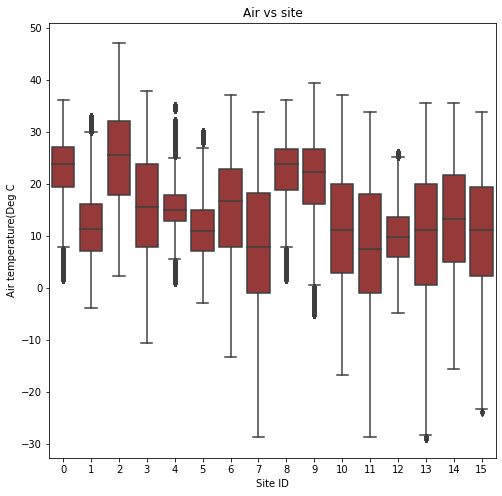

In [ ]:
plt.figure(figsize=(8,8))
air_site_df = train_df[["site_id", "air_temperature"]]
sns.boxplot(x = air_site_df["site_id"], y=air_site_df["air_temperature"], color="brown", data=air_site_df)
plt.xlabel("Site ID")
plt.ylabel("Air temperature(Deg C")
plt.title("Air vs site")
plt.show()

Distribution Plot: Dew temperature

In [ ]:
train_df.dew_temperature.describe()

count    2.011596e+07
mean              NaN
std      0.000000e+00
min     -3.500000e+01
25%      0.000000e+00
50%      8.898438e+00
75%      1.609375e+01
max      2.609375e+01
Name: dew_temperature, dtype: float64

In [ ]:
train_df.dew_temperature.isnull().sum()

100140

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


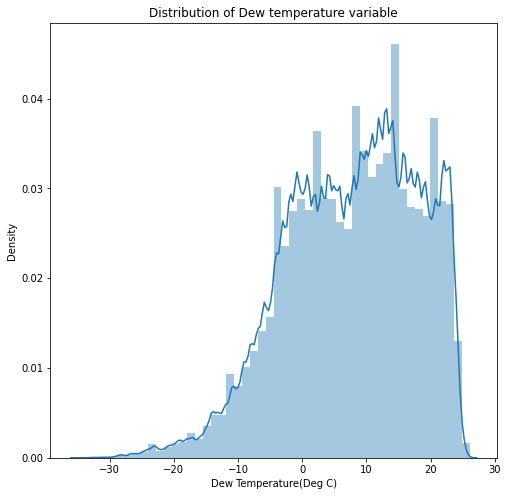

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['dew_temperature'].dropna())
plt.xlabel("Dew Temperature(Deg C)")
plt.title("Distribution of Dew temperature variable")
plt.show()

The dew temperature is bit skewed towards right. The maximum observations lie between -10-20 deg C

 Distribution plot: Cloud Coverage

In [ ]:
train_df.cloud_coverage.describe()

count    11390735.0
mean            NaN
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             4.0
max             9.0
Name: cloud_coverage, dtype: float64

In [ ]:
train_df.cloud_coverage.isnull().sum()

8825365

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


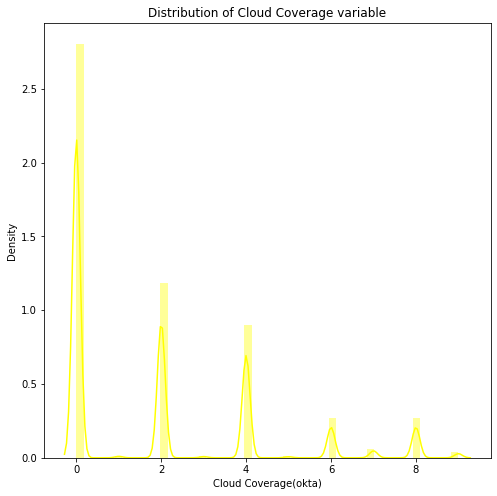

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['cloud_coverage'].dropna(), color='yellow')
plt.xlabel("Cloud Coverage(okta)")
plt.title("Distribution of Cloud Coverage variable")
plt.show()

Majority of the observations have cloud coverage as 0.Also there are misisng values 

Distribution Plot: precip_depth_1_hr

In [ ]:
train_df['precip_depth_1_hr'].isnull().sum()

3749023

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


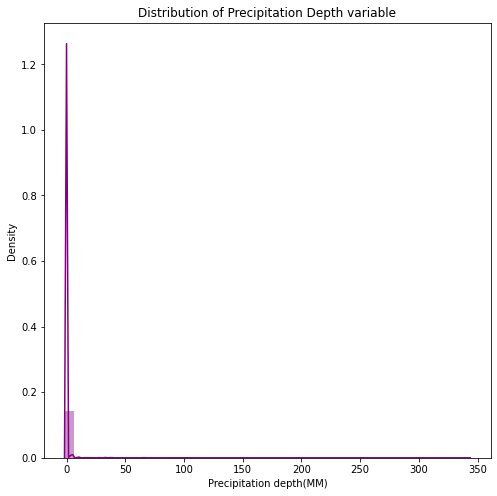

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['precip_depth_1_hr'], color='purple')
plt.xlabel("Precipitation depth(MM)")
plt.title("Distribution of Precipitation Depth variable")
plt.show()

The data is heavily skewed with maximum observations recording zero. Also there are lot of missing values in this variable.

 Distribution plot: Sea level pressure

In [ ]:
train_df.sea_level_pressure.describe()

count    18984431.0
mean            NaN
std             NaN
min           968.0
25%          1011.5
50%          1016.0
75%          1020.5
max          1046.0
Name: sea_level_pressure, dtype: float64

In [ ]:
train_df.sea_level_pressure.isnull().sum()

1231669

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


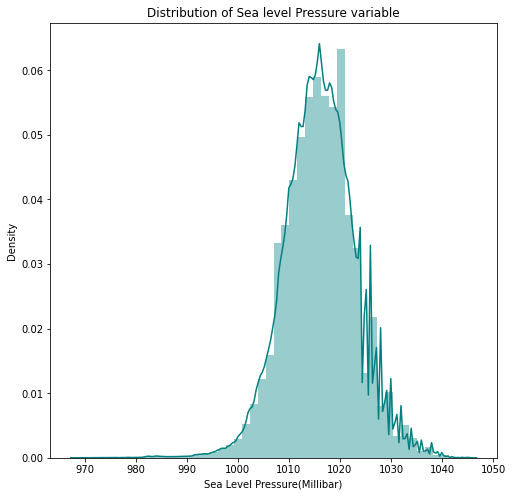

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['sea_level_pressure'].dropna(), color='teal')
plt.xlabel("Sea Level Pressure(Millibar)")
plt.title("Distribution of Sea level Pressure variable")
plt.show()

This follows a normal distribution with maximum of the observations lying between 1000 to 1030 millibar.

 Distribution plot: floor count

In [ ]:
train_df.floor_count.describe()

count    3.506933e+06
mean     4.184848e+00
std      4.008277e+00
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      2.600000e+01
Name: floor_count, dtype: float64

In [ ]:
train_df.floor_count.isnull().sum()

16709167

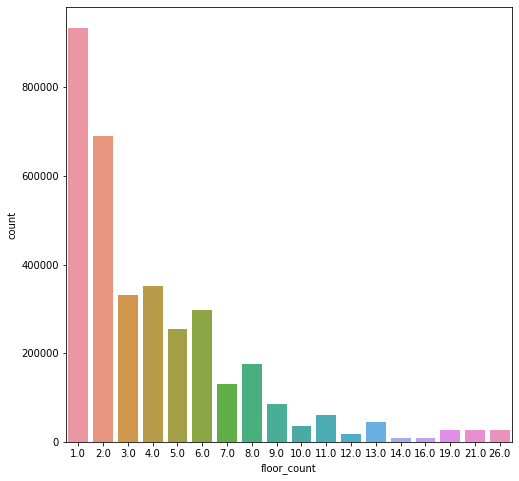

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x="floor_count", data=train_df) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


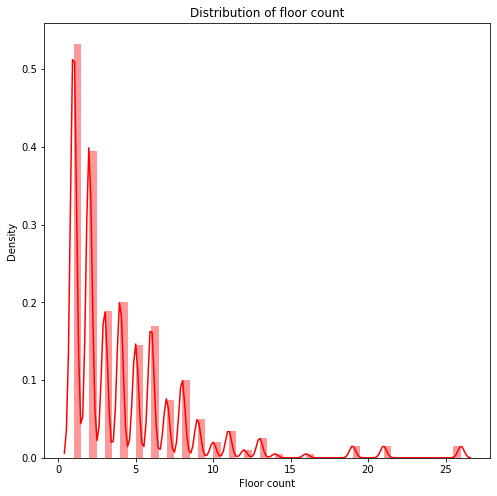

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['floor_count'].dropna(), color='red')
plt.xlabel("Floor count")
plt.title("Distribution of floor count")
plt.show()

The maximum buildings have floors less than 5.

box plot of floor count

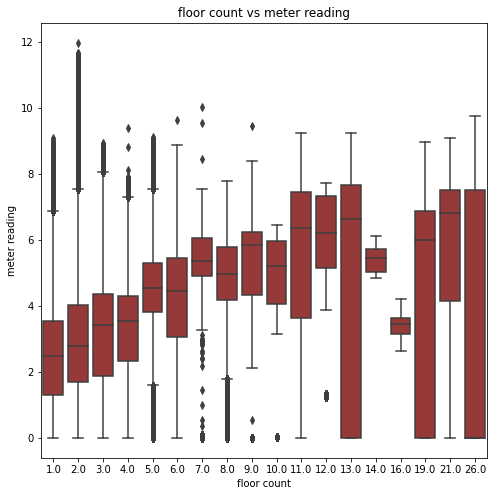

In [ ]:
plt.figure(figsize=(8,8))
floor_meter_df = train_df[["floor_count", "meter_reading"]]
sns.boxplot(x = floor_meter_df["floor_count"], y=floor_meter_df["meter_reading"], color="brown", data=floor_meter_df)
plt.xlabel("floor count")
plt.ylabel("meter reading")
plt.title("floor count vs meter reading")
plt.show()

Mean meter readings by floor count

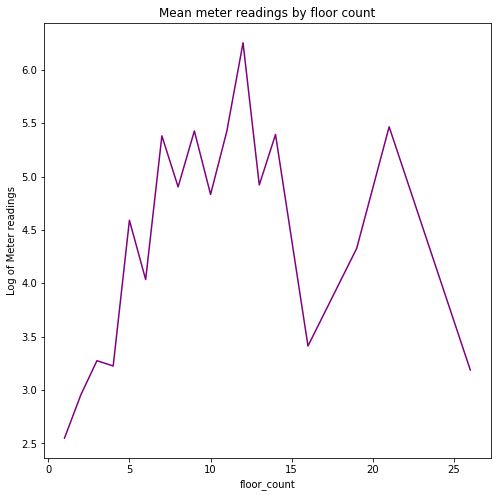

In [ ]:
plt.figure(figsize=(8,8))
floor_df= train_df.groupby('floor_count').meter_reading.mean().reset_index()
sns.lineplot(x=floor_df['floor_count'], y=floor_df['meter_reading'], color='purple')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by floor count")
plt.show()

A seen from above plot the rise is from fllor 10 to 14 and decreases then again increases it show that not all floors are operational all the time only some them are operational  

Distribution plot: Year built

In [ ]:
train_df.year_built.describe()

count    8.088455e+06
mean     1.968277e+03
std      3.020815e+01
min      1.900000e+03
25%      1.951000e+03
50%      1.969000e+03
75%      1.993000e+03
max      2.017000e+03
Name: year_built, dtype: float64

In [ ]:
train_df.year_built.isnull().sum()

12127645

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


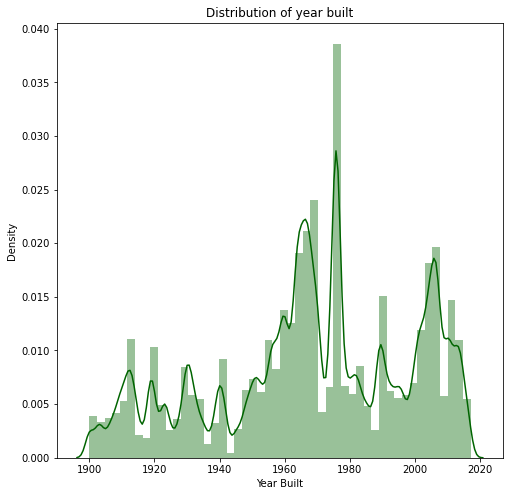

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['year_built'].dropna(), color='darkgreen')
plt.xlabel("Year Built")
plt.title("Distribution of year built")
plt.show()

The distribution is spread over a period of 120 years. Most of the buildings are built after 1960.

Count plot of year built

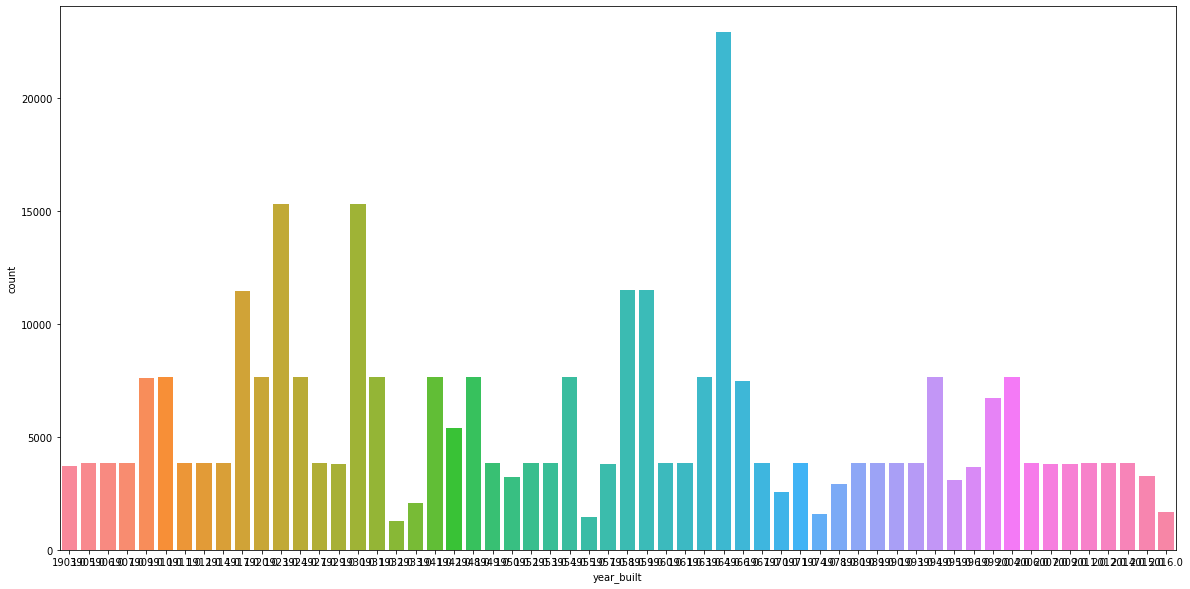

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="year_built", data=train_df.dropna(), saturation=1) 

Mean meter readings by year built

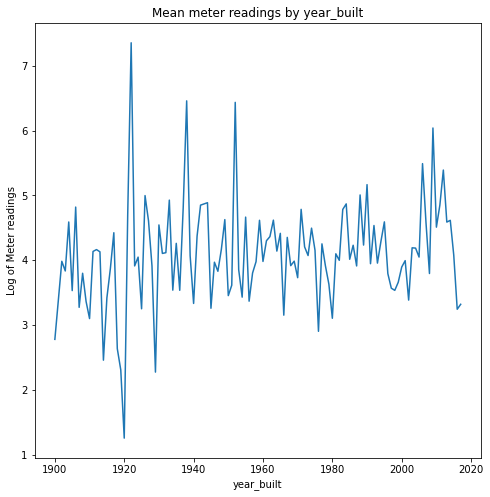

In [ ]:
plt.figure(figsize=(8,8))
year_df= train_df.groupby('year_built').meter_reading.mean().reset_index()
sns.lineplot(x=year_df['year_built'], y=year_df['meter_reading'])
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by year_built")
plt.show()

only few of the years build consumes more power but moslty are consumes nearly same power

Distribution plot: square feet

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


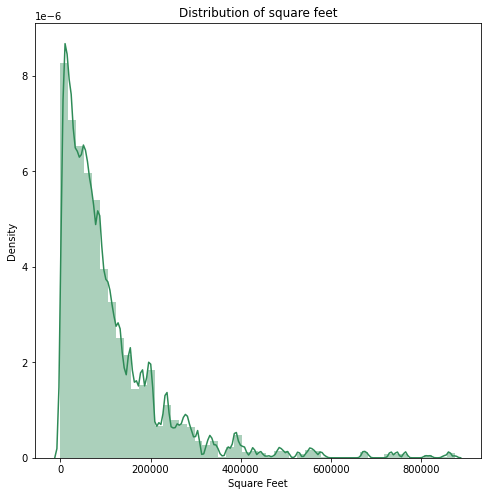

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['square_feet'], color='seagreen')
plt.xlabel("Square Feet")
plt.title("Distribution of square feet")
plt.show()

As the square feet is also heavily skewed and the scale of values is also very large hence we will apply a log transformation here and plot the distribution.

In [ ]:
train_df['square_feet']=np.log1p(train_df['square_feet'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


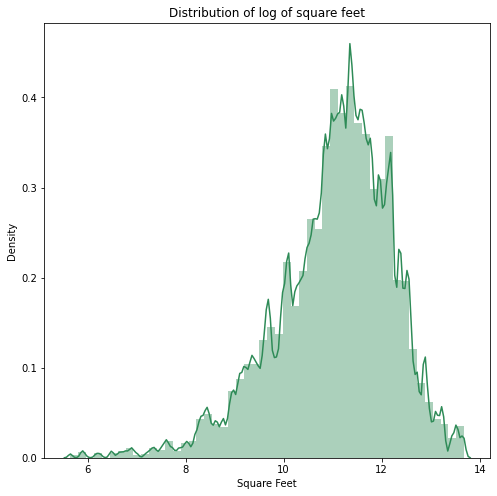

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['square_feet'], color='seagreen')
plt.xlabel("Square Feet")
plt.title("Distribution of log of square feet")
plt.show()

Now the distribution looks better after log transformations and almost gaussian 

Mean meter readings by square feet

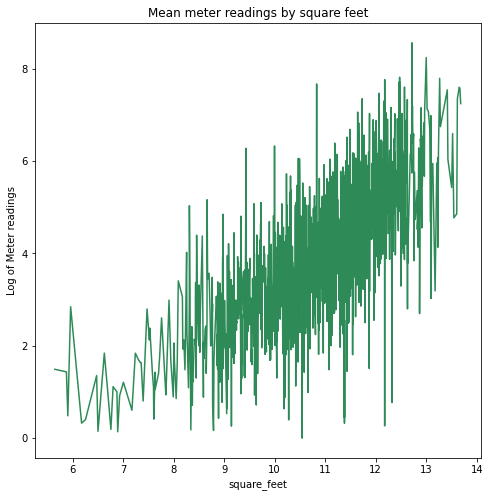

In [ ]:
plt.figure(figsize=(8,8))
sq_feet_df= train_df.groupby('square_feet').meter_reading.mean().reset_index()
sns.lineplot(x=sq_feet_df['square_feet'], y=sq_feet_df['meter_reading'], color='seagreen')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by square feet")
plt.show()

As the size of the building increases, the meter consumption also increases.

Sitewise Distribution

In [ ]:
train_df.site_id.value_counts()

13    2711763
9     2679323
2     2530312
14    2501506
3     2370097
15    1815054
0     1076662
5      781776
4      746746
6      668133
8      567915
1      553357
10     411407
7      366681
12     315909
11     119459
Name: site_id, dtype: int64

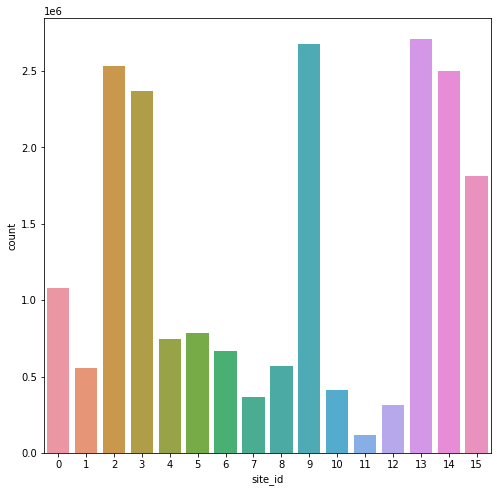

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x="site_id", data = train_df)

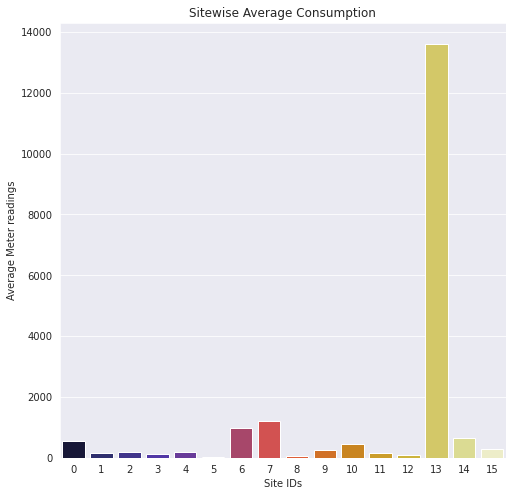

In [ ]:
#Sitewide consumption
plt.figure(figsize=(8,8))
site_df= train_df.groupby(['site_id']).meter_reading.mean().reset_index()
sns.barplot(x=site_df['site_id'], y=site_df['meter_reading'], palette='CMRmap')
plt.ylabel("Average Meter readings")
plt.xlabel("Site IDs")
plt.title("Sitewise Average Consumption")
plt.show()

Site13 records the highest average consumption followed by site7, site6. The minimum consumption is recorded by site5.

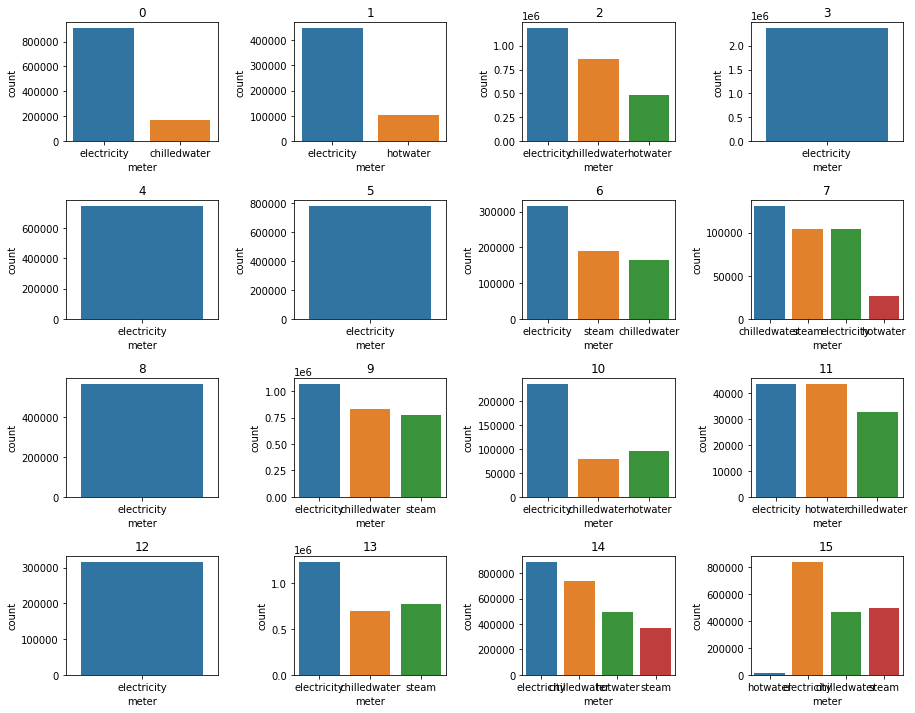

In [ ]:
#https://www.kaggle.com/masoudmzb/eda-how-to-detect-noises
fig, axes = plt.subplots(nrows=4, ncols=4)
fig.set_figheight(12)
fig.set_figwidth(15)
# fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
site_ids = train_df.site_id.unique()

for i, site_id in enumerate(site_ids):
    sns.countplot(x="meter", data = train_df[train_df.site_id  == site_id],ax=axes[i//4,i%4]).title.set_text(str(site_id))

Sitewise Hourly Average Consumption

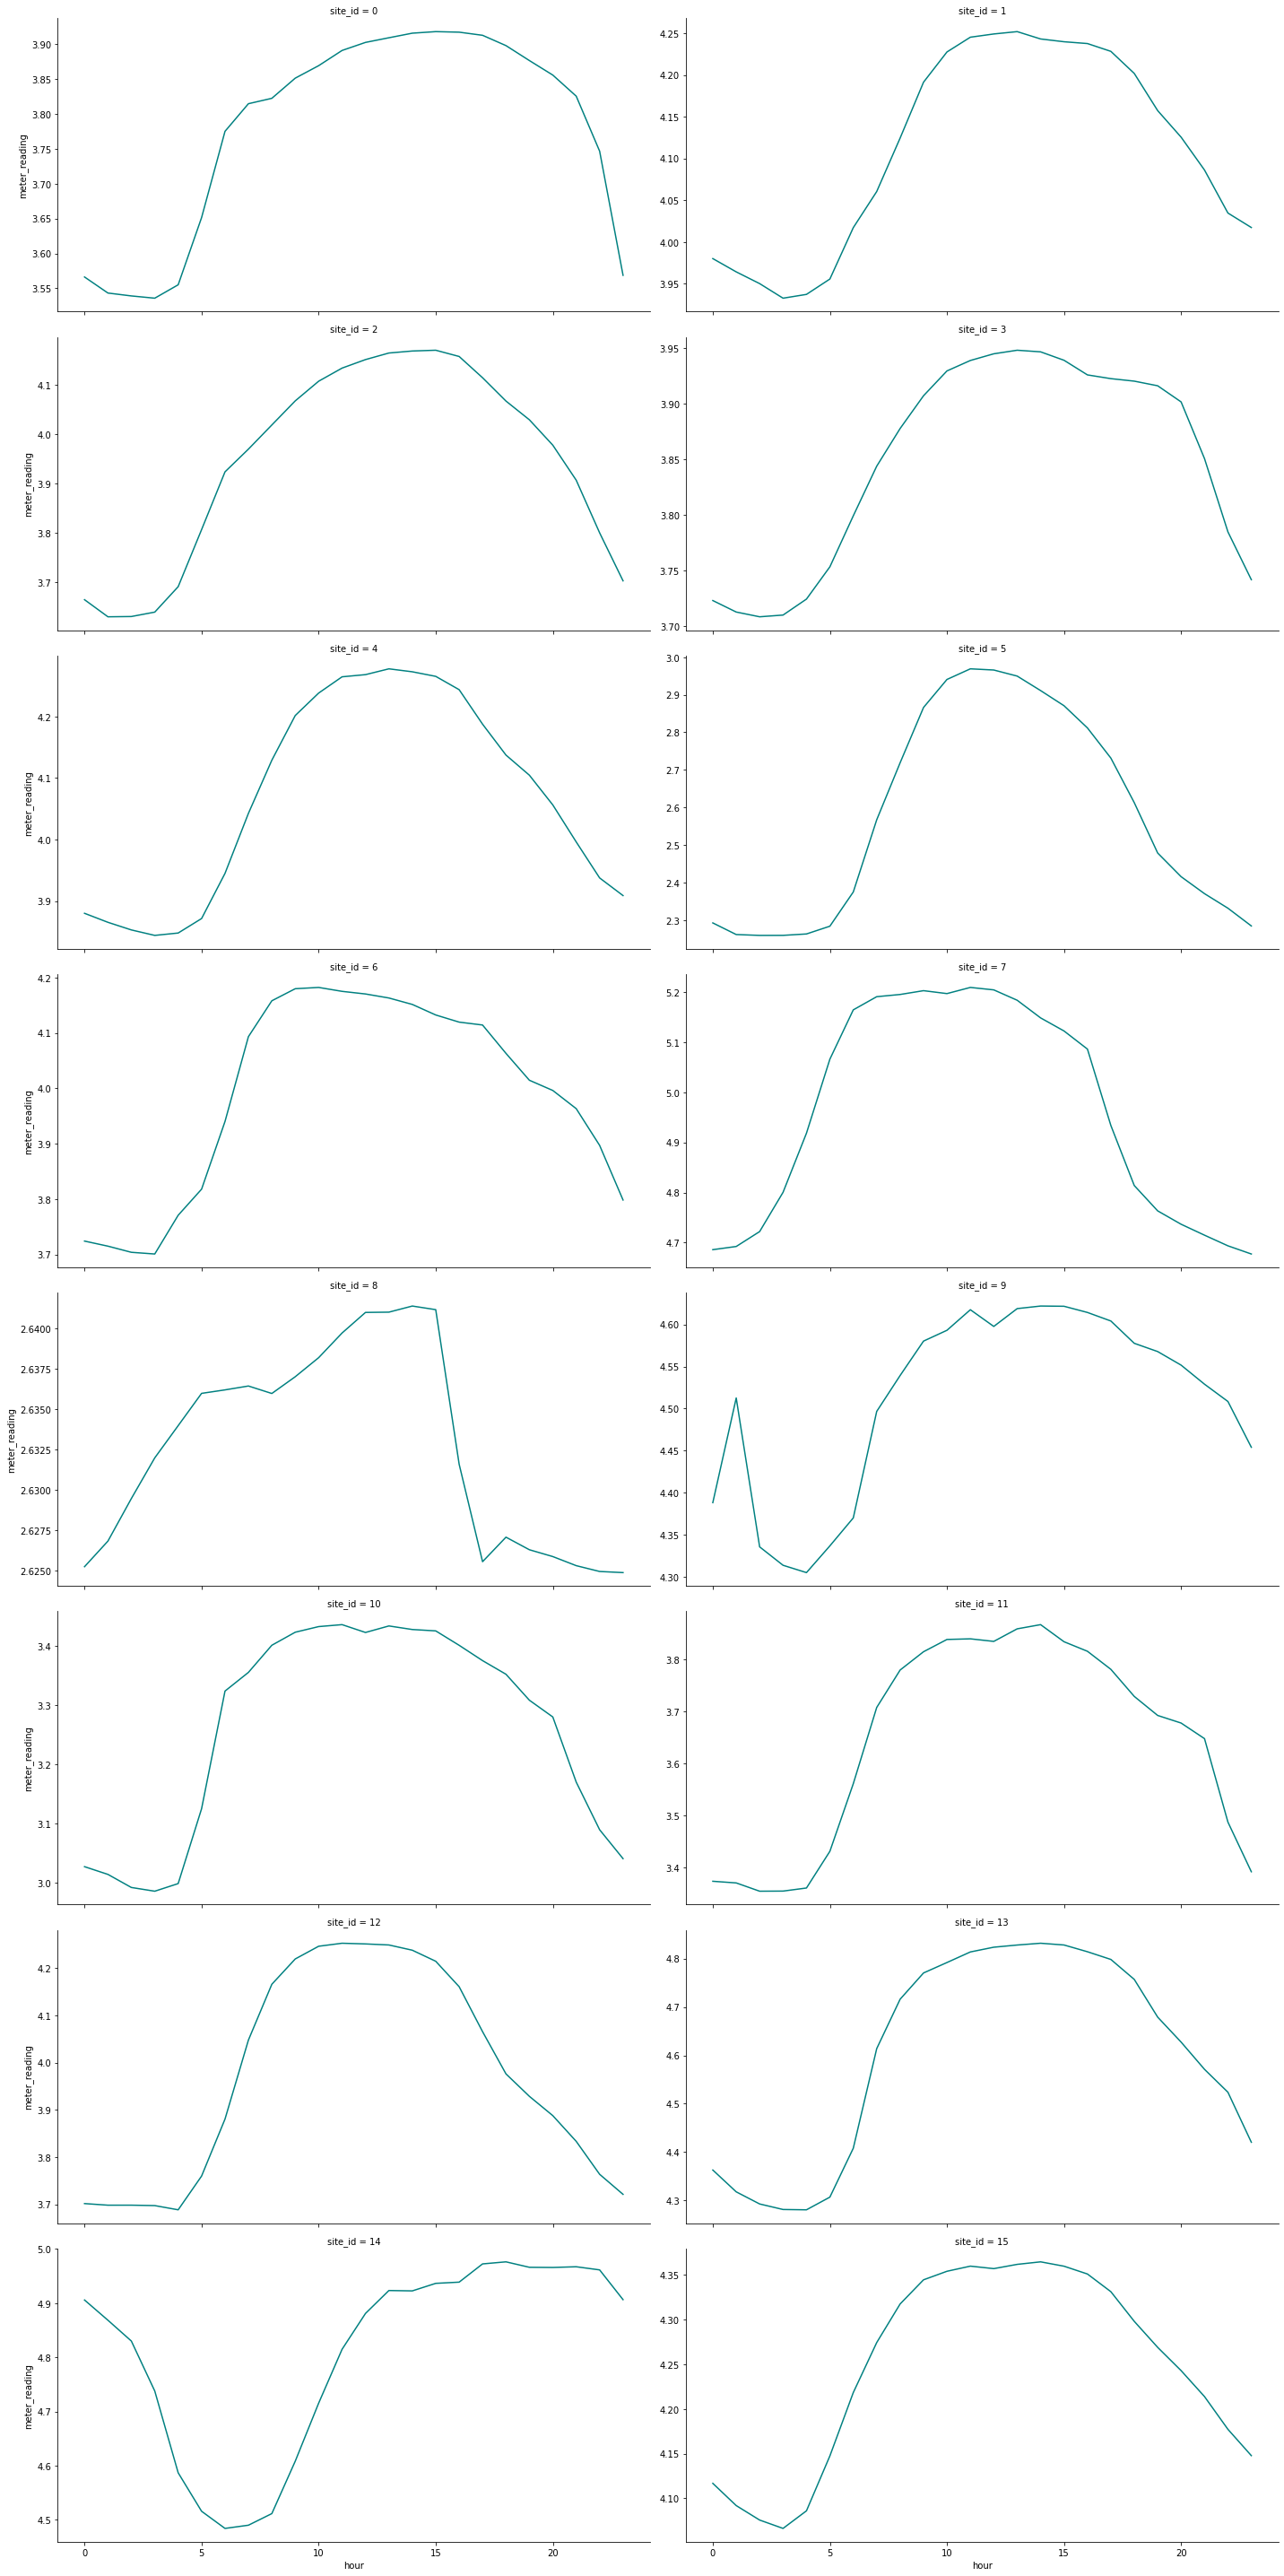

In [ ]:
hour_use_df= train_df.groupby(['site_id', 'hour']).meter_reading.mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='site_id', col_wrap=2, height=5, aspect=2, sharey=False)
p.map(sns.lineplot, 'hour', 'meter_reading', color='teal')
plt.show()

As we can see in the above plots, all the sites follow a similar usage patterns on hourly basis. The consumption drops to a minimum in the early hours of the day and then rises after 6am. It hits the peak in the afternoon and then drops after 7pm.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


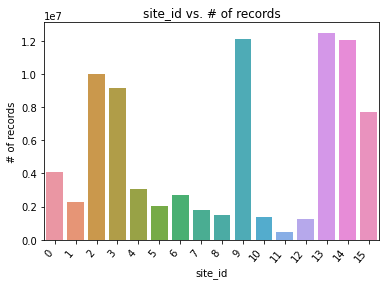

In [ ]:
ax = sns.barplot(train_df.groupby('site_id').meter_reading.agg('sum').reset_index()['site_id'],
                train_df.groupby('site_id').meter_reading.agg('sum').reset_index()['meter_reading'])
ax.set(xlabel='site_id', ylabel='# of records', title='site_id vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

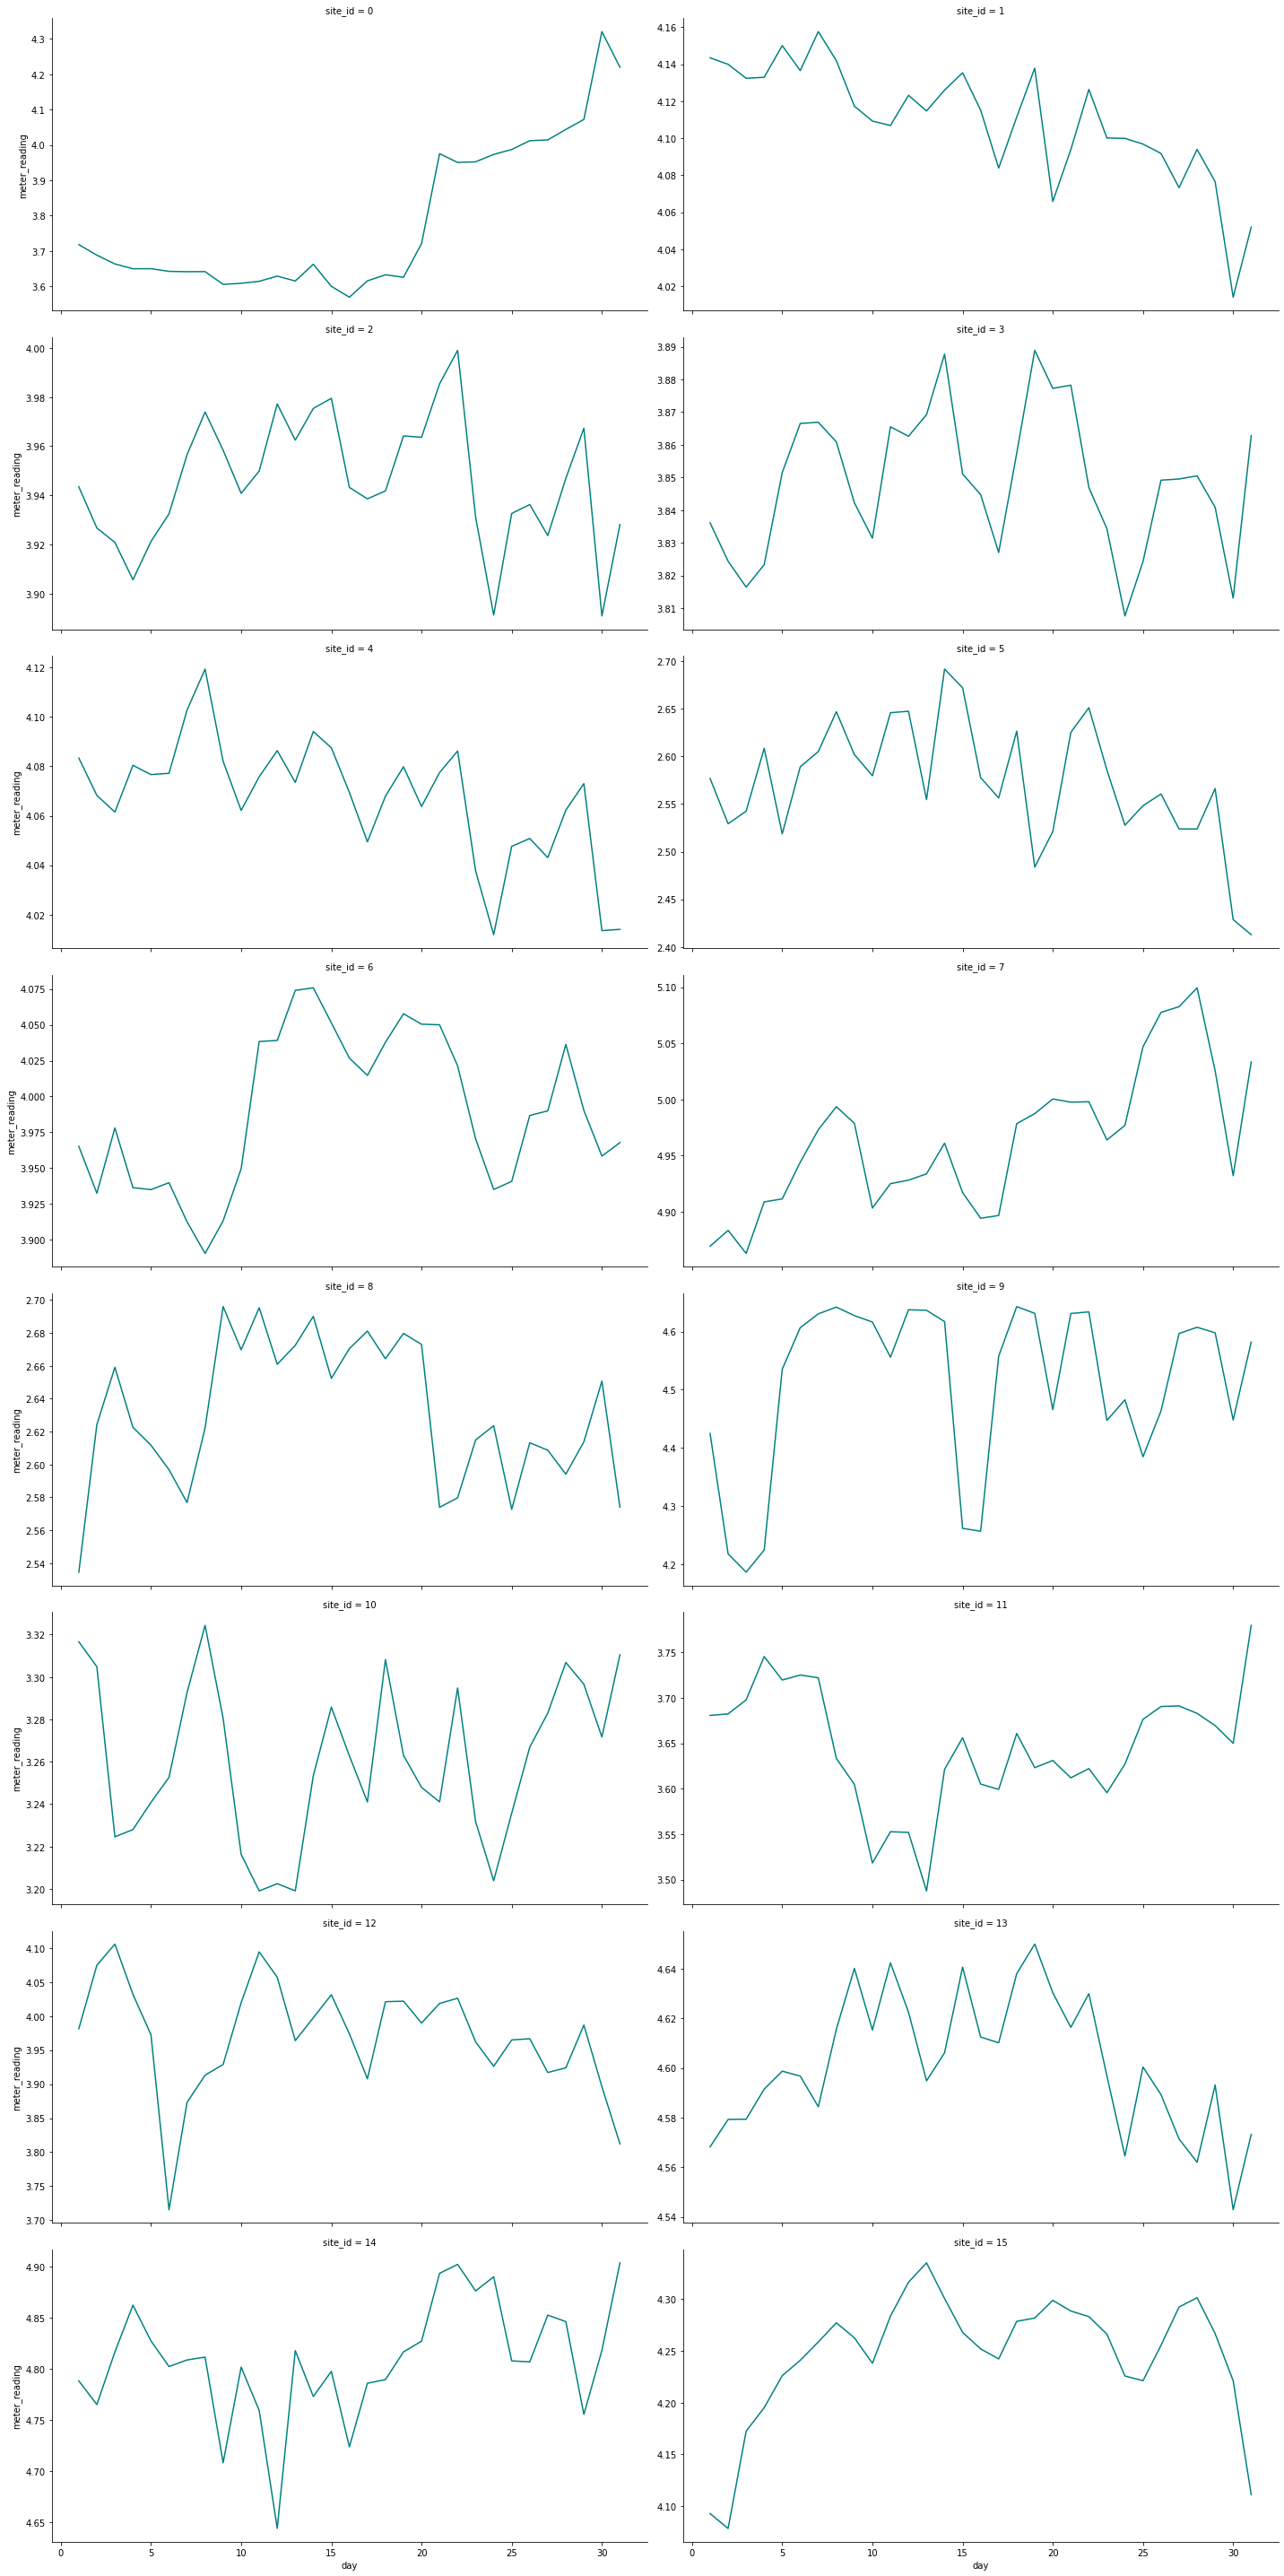

In [ ]:
day_use_df= train_df.groupby(['site_id', 'day']).meter_reading.mean().reset_index()
p=sns.FacetGrid(day_use_df, col='site_id', col_wrap=2, height=5, aspect=2, sharey=False)
p.map(sns.lineplot, 'day', 'meter_reading', color='teal')
plt.show()

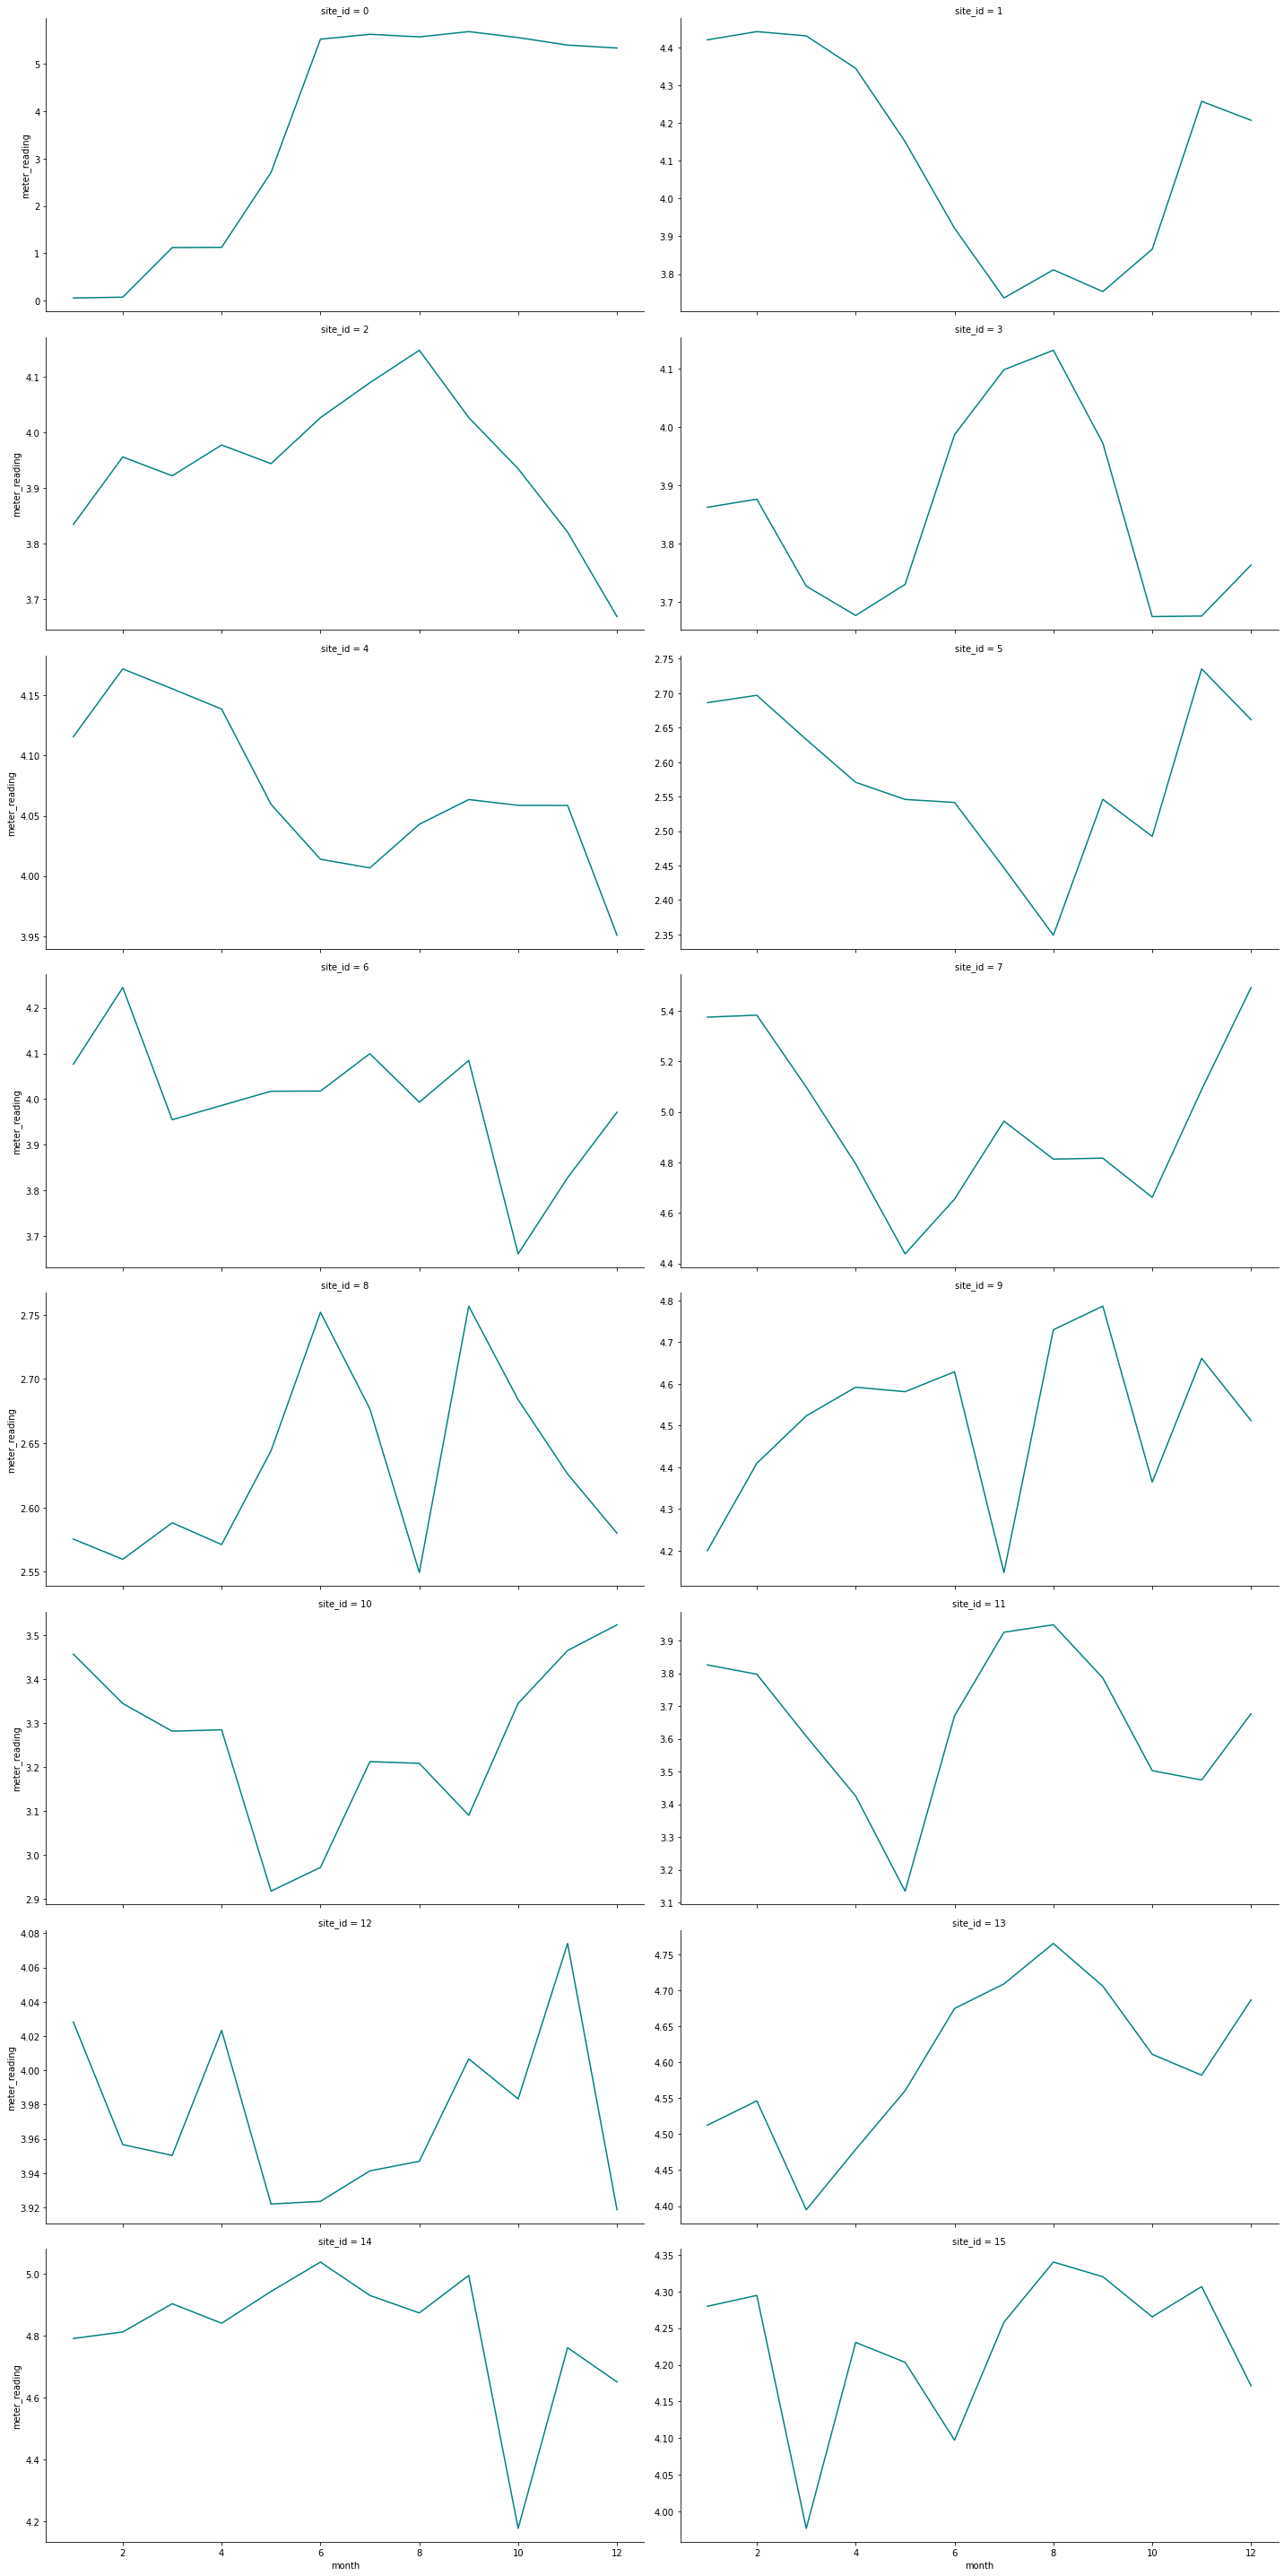

In [ ]:
month_use_df= train_df.groupby(['site_id', 'month']).meter_reading.mean().reset_index()
p=sns.FacetGrid(month_use_df, col='site_id', col_wrap=2, height=5, aspect=2, sharey=False)
p.map(sns.lineplot, 'month', 'meter_reading', color='teal')
plt.show()

There is no such common pattern is month while on the otherhand hours wise give more information than this plot

 Buildingwise Average meter readings

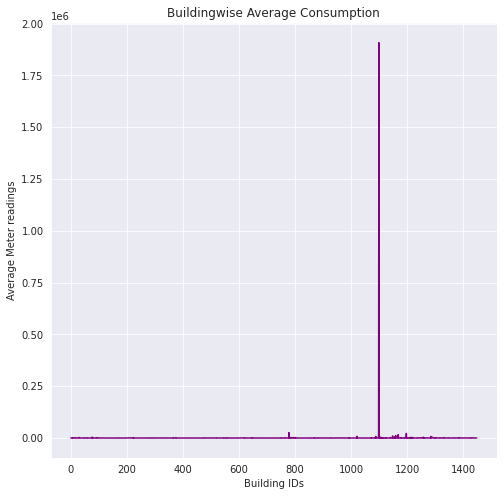

In [ ]:
plt.figure(figsize=(8,8))
site_df= train_df.groupby(['building_id']).meter_reading.mean().reset_index()
sns.lineplot(x=site_df['building_id'], y=site_df['meter_reading'], color='purple')
plt.ylabel("Average Meter readings")
plt.xlabel("Building IDs")
plt.title("Buildingwise Average Consumption")
plt.show()

In [ ]:
print(train_df[train_df.meter_reading == train_df.meter_reading.max()])

         building_id  meter           timestamp  ...  dayofyear  day  year
8907488         1099  steam 2016-06-13 09:00:00  ...        165   13  2016

[1 rows x 22 columns]


In [ ]:
train_df[(train_df['building_id']==1099)]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,dayofweek,month,dayofyear,day,year
1533,1099,electricity,2016-01-01 00:00:00,5.646323,13,Education,332884,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,0,4,1,1,1,2016
1534,1099,steam,2016-01-01 00:00:00,14.991587,13,Education,332884,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,0,4,1,1,1,2016
3829,1099,electricity,2016-01-01 01:00:00,5.646323,13,Education,332884,NaN,NaN,-8.296875,NaN,-11.703125,-1.0,1023.5,240.0,4.101562,1,4,1,1,1,2016
3830,1099,steam,2016-01-01 01:00:00,14.991587,13,Education,332884,NaN,NaN,-8.296875,NaN,-11.703125,-1.0,1023.5,240.0,4.101562,1,4,1,1,1,2016
6125,1099,electricity,2016-01-01 02:00:00,5.655516,13,Education,332884,NaN,NaN,-7.800781,NaN,-11.101562,-1.0,1023.0,240.0,3.099609,2,4,1,1,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210589,1099,steam,2016-12-31 21:00:00,8.476580,13,Education,332884,NaN,NaN,-4.398438,0.0,-11.703125,0.0,1009.5,240.0,4.101562,21,5,12,366,31,2016
20212955,1099,electricity,2016-12-31 22:00:00,5.587331,13,Education,332884,NaN,NaN,-5.000000,0.0,-11.703125,0.0,1010.0,230.0,4.601562,22,5,12,366,31,2016
20212956,1099,steam,2016-12-31 22:00:00,8.496378,13,Education,332884,NaN,NaN,-5.000000,0.0,-11.703125,0.0,1010.0,230.0,4.601562,22,5,12,366,31,2016
20215320,1099,electricity,2016-12-31 23:00:00,5.578556,13,Education,332884,NaN,NaN,-5.601562,4.0,-11.101562,0.0,1010.0,240.0,3.599609,23,5,12,366,31,2016


As we can see from the above plot, the meter readings vary accross the buildings. Building 1099 have a huge spike in their usage while many buildings use very less energy. It will be considered as an outlier.


In [ ]:
!pip install windrose

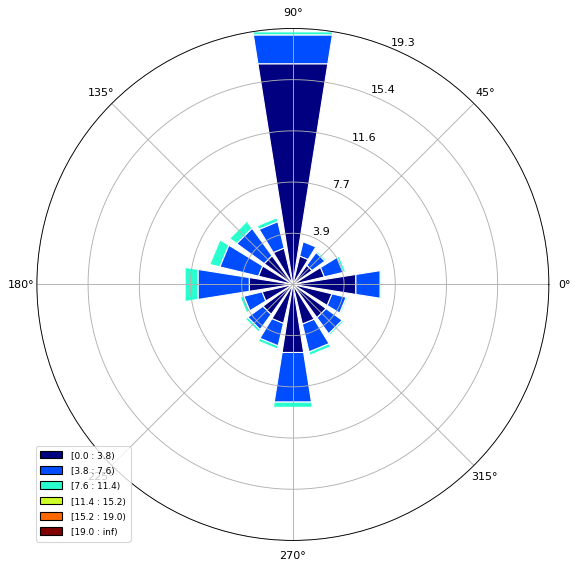

In [ ]:
#https://www.kaggle.com/nroman/eda-for-ashrae
#https://windrose.readthedocs.io/en/latest/usage.html
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(train_df['wind_direction'], train_df['wind_speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

The above windrose diagram shows that for most of the sites, the wind blows from north direction(90 degrees) most of the time, followed by south direction(270 degrees). It also shows that wind blows the least from NE direction(45 degrees). When the wind blows from the north, maximum of the times the speed is between 0 to 3.8 m/s.

sea level pressure

In [ ]:
train_df.sea_level_pressure.isnull().sum()

1231669

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


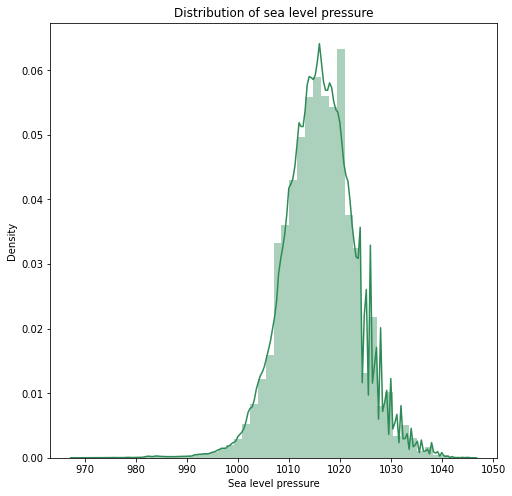

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['sea_level_pressure'].dropna(), color='seagreen')
plt.xlabel("Sea level pressure")
plt.title("Distribution of sea level pressure")
plt.show()

It almost follows the gauusian distribution and the peaks is in between 1000 and 1030

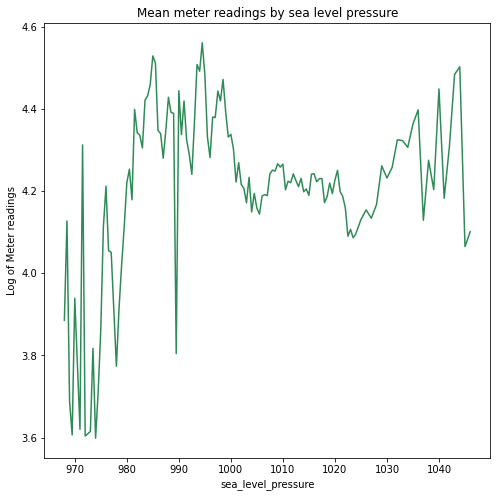

In [ ]:
plt.figure(figsize=(8,8))
sea_df= train_df.groupby('sea_level_pressure').meter_reading.mean().reset_index()
sns.lineplot(x=sea_df['sea_level_pressure'], y=sea_df['meter_reading'], color='seagreen')
plt.ylabel("Log of Meter readings")
plt.title("Mean meter readings by sea level pressure")
plt.show()

Initally it is low then increase

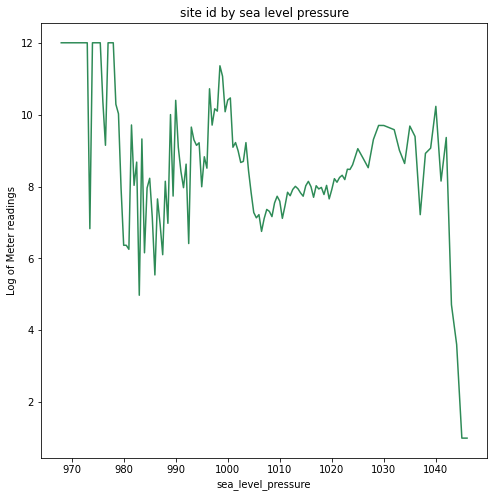

In [ ]:
plt.figure(figsize=(8,8))
sea_df= train_df.groupby('sea_level_pressure').site_id.mean().reset_index()
sns.lineplot(x=sea_df['sea_level_pressure'], y=sea_df['site_id'], color='seagreen')
plt.ylabel("Log of Meter readings")
plt.title("site id by sea level pressure")
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

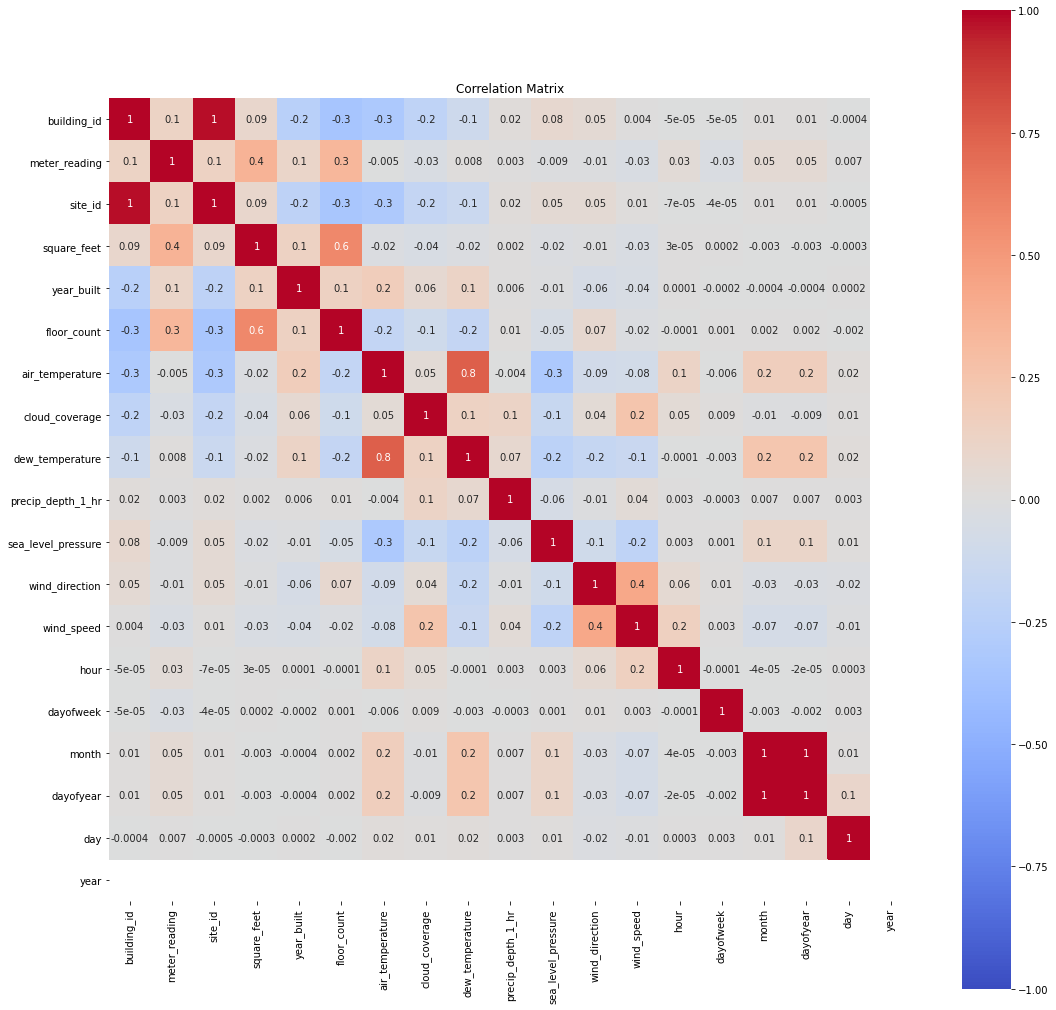

In [ ]:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
#Correlation Matrix
plt.figure(figsize=(18,18))
sns.heatmap(train_df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='coolwarm')
plt.title('Correlation Matrix') 

I have plotted the correlation matrix of the features available. The square feet and floor count features have a positive correlation with the target variable. The site id and buildind id are highlg corelated

bivariate analysis on site_id ans building_id

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


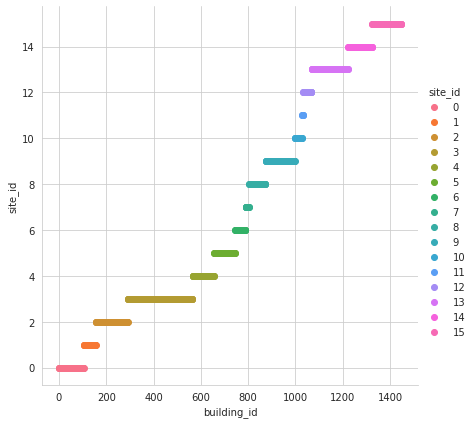

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(building_data, hue="site_id", size=6) \
    .map(plt.scatter, "building_id", "site_id") \
    .add_legend()
plt.show()

There is a positive relation between site id and building id.It also seems building ids are assigned in a sequential manner, one after another.
You can also see most of the buildings are from site 3, and hence the majority of train data has come from site 3.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


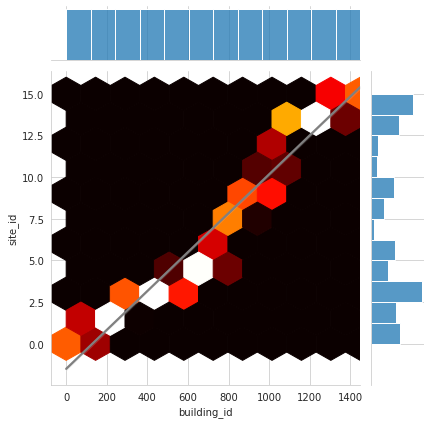

In [ ]:
g = sns.jointplot(x = 'building_id', 
              y = 'site_id',
              data = building_data, 
              kind = 'hex', 
              cmap= 'hot', 
              size=6)

#http://stackoverflow.com/questions/33288830/how-to-plot-regression-line-on-hexbins-with-seaborn
sns.regplot(building_data.building_id, building_data.site_id, ax=g.ax_joint, scatter=False, color='grey');

We can see that the line almost fit our building data here which shows that there is some relation between my site id and my building id

In [ ]:
building_data.columns

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')

bivariate analysis on floor_count ans square_feet

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


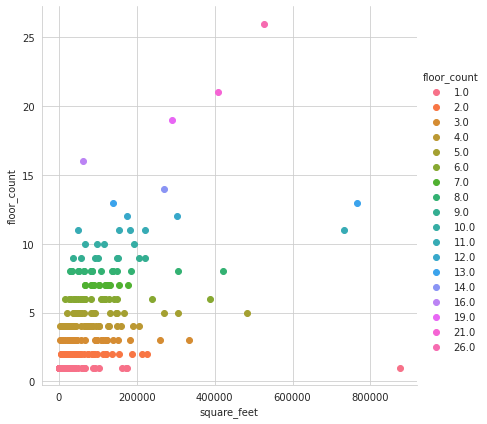

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(building_data, hue="floor_count", size=6) \
    .map(plt.scatter, "square_feet", "floor_count") \
    .add_legend()
plt.show()

The majority of the buildings have 0 -10 floors and in between 0-200000 square feet 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


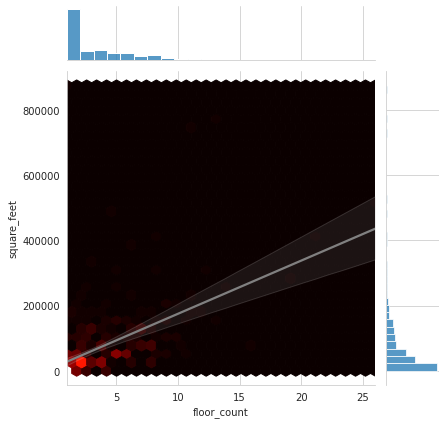

In [ ]:
g = sns.jointplot(x = 'floor_count', 
              y = 'square_feet',
              data = building_data, 
              kind = 'hex', 
              cmap= 'hot', 
              size=6)

#http://stackoverflow.com/questions/33288830/how-to-plot-regression-line-on-hexbins-with-seaborn
sns.regplot(building_data.floor_count, building_data.square_feet, ax=g.ax_joint, scatter=False, color='grey');

As we can see that ther is some relation between the floor count and square feet if floor count increases then sqaure feet increases upto some extent

bivariate analysis on air_temperature ans dew_temperature

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


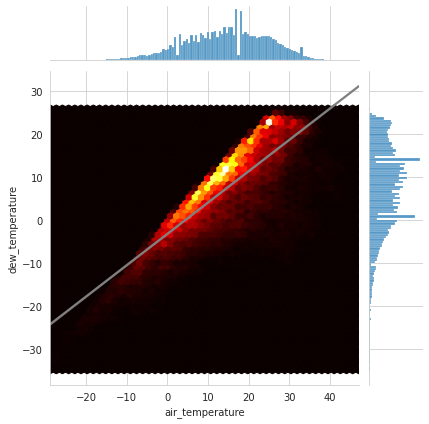

In [ ]:
g = sns.jointplot(x = 'air_temperature', 
              y = 'dew_temperature',
              data = weather_train_data, 
              kind = 'hex', 
              cmap= 'hot', 
              size=6)

#http://stackoverflow.com/questions/33288830/how-to-plot-regression-line-on-hexbins-with-seaborn
sns.regplot(weather_train_data.air_temperature, weather_train_data.dew_temperature, ax=g.ax_joint, scatter=False, color='grey');

There is some positive relation between the dew temperature and air temperature 


bivariate analysis on square_feet ans meter_reading

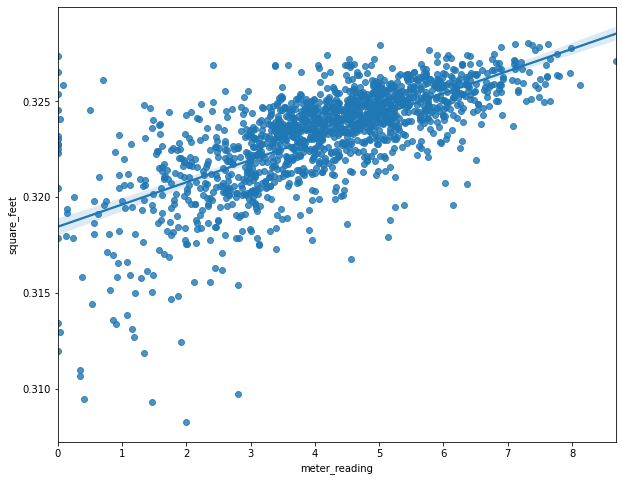

In [ ]:
#https://stackoverflow.com/questions/58591837/mean-is-not-definedin-agg-python
plt.figure(figsize=(10,8))
building_median_meter_reading = train_df.groupby("building_id").agg({"meter_reading": "median"}).reset_index()

building_data["square_feet"] = np.log1p(building_data["square_feet"])

merged_data = building_median_meter_reading.reset_index().merge(building_data[["building_id", "square_feet", "primary_use"]], on="building_id", how='left')
# regplot
sns.regplot(x = "meter_reading",y= "square_feet" , data= merged_data)


We can clearly see that there is positive relation between median meter reading and square feet (in log scale).

bivariate analysis on floor_count ans meter_reading

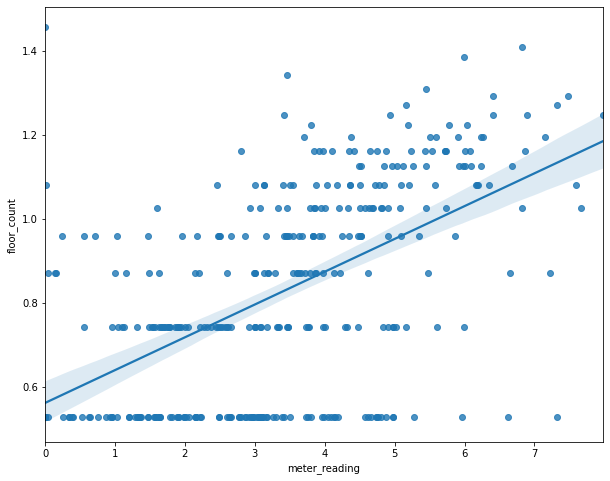

In [ ]:
#https://stackoverflow.com/questions/58591837/mean-is-not-definedin-agg-python
plt.figure(figsize=(10,8))
building_median_meter_reading = train_df.groupby("building_id").agg({"meter_reading": "median"}).reset_index()

building_data["floor_count"] = np.log1p(building_data["floor_count"])

merged_data = building_median_meter_reading.reset_index().merge(building_data[["building_id", "floor_count", "primary_use"]], on="building_id", how='left')
# regplot
sns.regplot(x = "meter_reading",y= "floor_count" , data= merged_data)


We can see there is some positive relation between median meter reading and floor count (in log scale). 

Observations after doing EDA
1. In Building id there is an outlier buidling_id = 1099 i have to remove it during preprocessing stage
2. i have to drop floor_count and year_built before feed to my model because more than 50% of data is missing here
3. There is some positive relation between the square feet and the meter reading
4. There is some positive relation between the site id and the building id
5. There is some positive relation between the air temperature and the dew temperature
6. There are some missing values which i have to impute in the preprocessing stage
7. There are lot of zero meter reading in electirc meter 
8.  There is some positive relation between the square feet and the floor count
9. the correlation matrix plays an important role because of this i will come up with some new fetaures based on the correlation 

Reference
1. https://www.kaggle.com/masoudmzb/eda-how-to-detect-noises
2. https://www.kaggle.com/nroman/eda-for-ashrae